# SPOTIFY DATASET ANALYSIS

###Introduction

The Spotify dataset provides detailed information about tracks, including their audio features such as danceability, energy, tempo, acousticness, instrumentalness, speechiness, loudness, valence, and popularity. This project performs an Exploratory Data Analysis (EDA) to uncover trends in music production and popularity.
The objective is to identify what makes a track popular, how audio features interact, and how popular music has evolved over time.


###Methodology

* Dataset Used: Cleaned Spotify dataset (containing features and popularity scores).

* Approach:

  * Univariate Analysis: To understand individual feature distributions.

  * Bivariate Analysis: To study relationships between two features and popularity.

  * Multivariate Analysis: To identify combinations of features influencing success.

  * Time Series Analysis: To track trends in features and popularity across years.

* Tools & Libraries: Python, Pandas, Matplotlib, Seaborn, Pygam, Statsmodels, Scipy, Sklearn.

###SPOTIFY DATA DESCRIPTION


**track_id**: A unique identifier for the track on Spotify

**track_name**: The title of the song

**artist_name**: The name of the artist(s) who performed the song

**year**: The release year of the song

**popularity**: A measure of how popular a track is, ranging from 0 to 100

**artwork_url**: A URL pointing to the album artwork for the track

**album_name**: The name of the album the track belongs to

**acousticness**: A confidence measure indicating whether the track is acoustic, ranging from -1.0 to 1.0

**danceability**: A measure of how suitable a track is for dancing, ranging from -1.0 to +1.0

**duration_ms**: The duration of the track in milliseconds

**energy**: A perceptual measure of intensity and activity, ranging from -1.0 to 1.0

**instrumentalness**: Predicts whether a track contains no vocal content, ranging from -1.0 to +1.0

**key**: The key the track is in, represented as an integer (e.g., 0 = C, 1 = C#, etc.)

**liveness**: Detects the presence of an audience in the recording, ranging from -1.0 to +1.0

**loudness**: The overall loudness of a track in decibels (dB)

**mode**: Indicates the modality (major or minor) of a track (0 for minor, 1 for major)

**speechiness**: A measure detecting the presence of spoken words in a track

**tempo**: The overall estimated tempo of a track in beats per minute (BPM)

**time_signature**: An estimated overall time signature of a track

**valence**: A measure from -1.0 to 1.0 describing the musical positiveness conveyed by a track

**track_url**: A URL to the Spotify track

**language**: The detected language of the song's lyrics



###STEP 1: Import Libraries

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import gaussian_filter
from pygam import LinearGAM, s
from sklearn.neighbors import KNeighborsRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

###STEP 2: Load and Read Data

In [97]:
df = pd.read_csv("spotify_tracks.csv")

### STEP 3: Basic Data Overview

In [98]:
print("First 5 rows:\n", df.head())
print("\nShape of dataset:", df.shape)
print("\nColumn info:")
print(df.info())
print("\nSummary statistics:\n", df.describe(include='all'))

First 5 rows:
                  track_id                                  track_name  \
0  2r0ROhr7pRN4MXDMT1fEmd                  Leo Das Entry (From "Leo")   
1  4I38e6Dg52a2o2a8i5Q5PW                                AAO KILLELLE   
2  59NoiRhnom3lTeRFaBzOev      Mayakiriye Sirikiriye - Orchestral EDM   
3  5uUqRQd385pvLxC8JX3tXn    Scene Ah Scene Ah - Experimental EDM Mix   
4  1KaBRg2xgNeCljmyxBH1mo  Gundellonaa X I Am A Disco Dancer - Mashup   

                                         artist_name  year  popularity  \
0                                Anirudh Ravichander  2024          59   
1  Anirudh Ravichander, Pravin Mani, Vaishali Sri...  2024          47   
2           Anirudh Ravichander, Anivee, Alvin Bruno  2024          35   
3  Anirudh Ravichander, Bharath Sankar, Kabilan, ...  2024          24   
4  Anirudh Ravichander, Benny Dayal, Leon James, ...  2024          22   

                                         artwork_url  \
0  https://i.scdn.co/image/ab67616d0000b273ce

###STEP 4: Checking and Handling Missing Values

In [99]:
print("\nMissing values per column:\n", df.isnull().sum())
for col in df.columns:
    if df[col].dtype in ['int64','float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after cleaning:\n", df.isnull().sum())


Missing values per column:
 track_id            0
track_name          0
artist_name         0
year                0
popularity          0
artwork_url         0
album_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
track_url           0
language            0
dtype: int64

Missing values after cleaning:
 track_id            0
track_name          0
artist_name         0
year                0
popularity          0
artwork_url         0
album_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
t

###STEP 5: Duplicate Records

In [100]:
print("\nDuplicate rows before removal:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Duplicate rows after removal:", df.duplicated().sum())


Duplicate rows before removal: 78
Duplicate rows after removal: 0


###STEP 6: Outlier Detection (IQR method)

In [101]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col}: {len(outliers)} outliers detected")

year: 4072 outliers detected
popularity: 1115 outliers detected
acousticness: 35 outliers detected
danceability: 1276 outliers detected
duration_ms: 2272 outliers detected
energy: 35 outliers detected
instrumentalness: 14217 outliers detected
key: 0 outliers detected
liveness: 4219 outliers detected
loudness: 4047 outliers detected
mode: 0 outliers detected
speechiness: 7357 outliers detected
tempo: 412 outliers detected
time_signature: 8979 outliers detected
valence: 35 outliers detected


###STEP 7: Fixing Data Types

In [102]:
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

print("\nData types after conversion:\n", df.dtypes)


Data types after conversion:
 track_id             object
track_name           object
artist_name          object
year                  int64
popularity            int64
artwork_url          object
album_name           object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
mode                float64
speechiness         float64
tempo               float64
time_signature      float64
valence             float64
track_url            object
language             object
dtype: object


###STEP 8: Save Cleaned Data

In [103]:
df.to_csv("spotify_tracks_cleaned.csv", index=False)
print("\nCleaned dataset saved as spotify_tracks_cleaned.csv")


Cleaned dataset saved as spotify_tracks_cleaned.csv


##UNIVARIATE ANALYSIS

1. What is the overall distribution of popularity scores across all tracks in the dataset? (Are most songs moderately popular, or is it skewed towards very high/low popularity?)

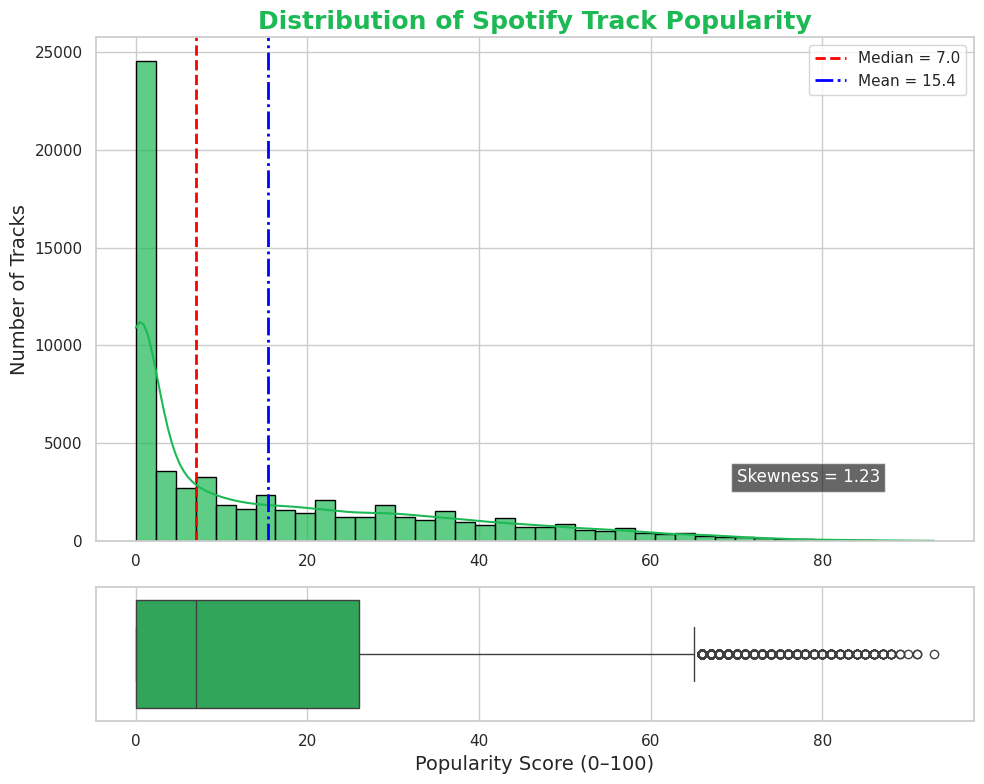

In [104]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,8),
    gridspec_kw={"height_ratios":[3, 0.8]}
)

sns.set_style("whitegrid")

# Histogram + KDE

sns.histplot(df["popularity"], bins=40, kde=True, color="#1DB954", edgecolor="black", alpha=0.7, ax=ax1)


median_val = df["popularity"].median()
mean_val = df["popularity"].mean()
ax1.axvline(median_val, color="red", linestyle="--", linewidth=2, label=f"Median = {median_val}")
ax1.axvline(mean_val, color="blue", linestyle="-.", linewidth=2, label=f"Mean = {mean_val:.1f}")


skewness = df["popularity"].skew()
ax1.text(70, 3000, f"Skewness = {skewness:.2f}", fontsize=12, color="white",
         bbox=dict(facecolor="black", alpha=0.6))

ax1.set_title("Distribution of Spotify Track Popularity", fontsize=18, weight="bold", color="#1DB954")
ax1.set_xlabel("")
ax1.set_ylabel("Number of Tracks", fontsize=14)
ax1.legend()

#  Boxplot

sns.boxplot(x=df["popularity"], color="#1DB954", ax=ax2)
ax2.set_xlabel("Popularity Score (0–100)", fontsize=14)
ax2.set_yticks([])

plt.tight_layout()
plt.show()

Breakdown of track popularity categories:

Low (0–30): 79.15% of tracks

Medium (31–70): 19.95% of tracks

High (71–100): Only 0.89% of tracks

INSIGHTS:

Most tracks have very low popularity (<30).

The median (approx 7) and mean (approx 15) are both on the low side.

The distribution is right-skewed, with a long tail toward high popularity.

Only a small fraction of songs reach high popularity (above 70).

The boxplot highlights many outliers at the higher end, representing hit songs.


------------------------------------------------------------------------------

2. What is the average and typical range for duration_ms (song length)?

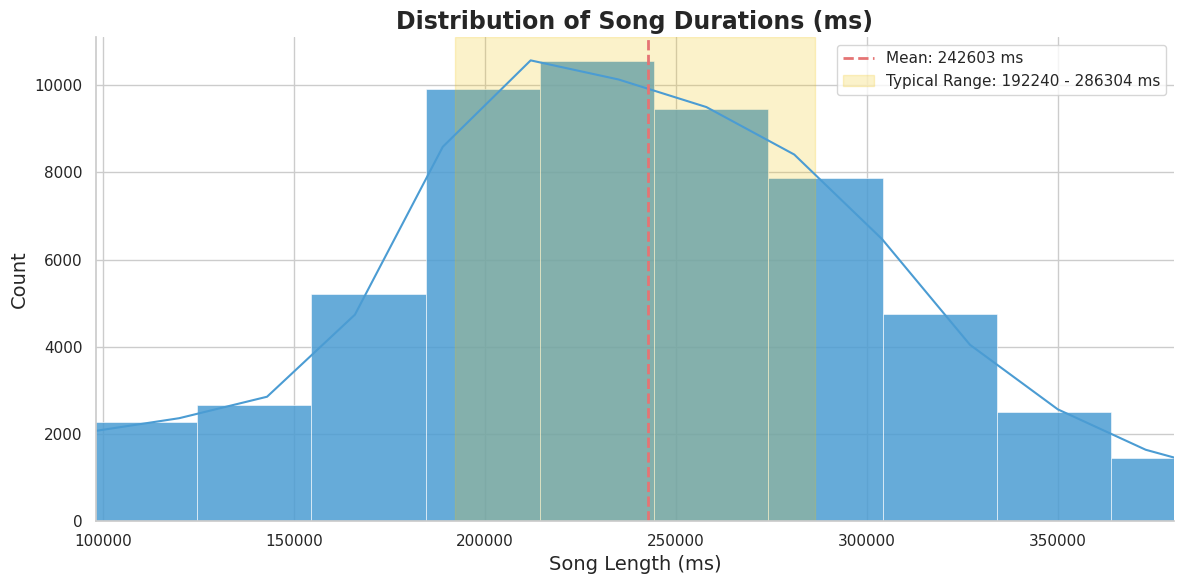

Average song duration: 242603.45 ms
Typical range (25th to 75th percentile): 192240.00 ms to 286303.50 ms


In [105]:
#Distribution of Song Durations

plt.figure(figsize=(12,6))

mean_duration = df['duration_ms'].mean()
q25 = df['duration_ms'].quantile(0.25)
q75 = df['duration_ms'].quantile(0.75)


sns.histplot(
    df['duration_ms'],
    binwidth=30000,
    kde=True,
    color='#4B9CD3',
    edgecolor='white',
    alpha=0.85
)


plt.axvline(mean_duration, color='#E57474', linestyle='--', linewidth=2, label=f'Mean: {mean_duration:.0f} ms')
plt.axvspan(q25, q75, color='#F1C40F', alpha=0.22, label=f'Typical Range: {q25:.0f} - {q75:.0f} ms')

plt.title('Distribution of Song Durations (ms)', fontsize=17, weight='bold')
plt.xlabel('Song Length (ms)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(q25 - (q75-q25), q75 + (q75-q25))
plt.legend()
plt.tight_layout()
sns.despine()
plt.show()


INSIGHT:

Average song duration: 242603.45 ms

Typical range (25th to 75th percentile): 192240.00 ms to 286303.50 ms

---------------------------------------------------------

3. What are the most frequently occurring keys in the  dataset, and what is their individual distribution?

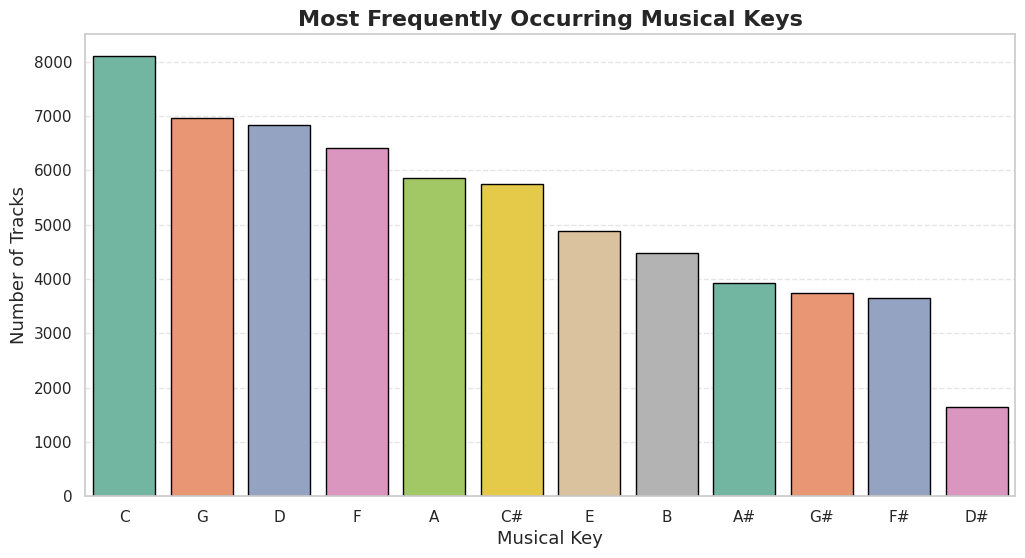

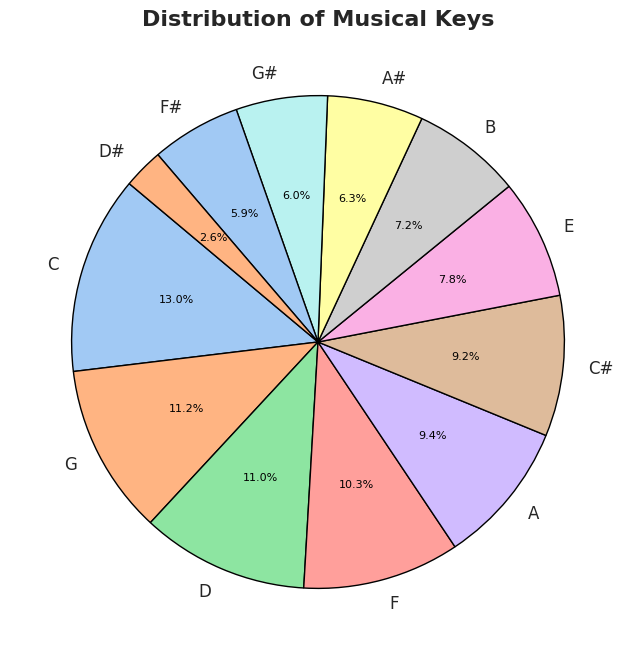

Key Frequencies:
   Key  Count
0    C   8101
1    G   6956
2    D   6832
3    F   6411
4    A   5862
5   C#   5744
6    E   4879
7    B   4473
8   A#   3920
9   G#   3735
10  F#   3655
11  D#   1636


In [106]:
key_mapping = {
    0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E",
    5: "F", 6: "F#", 7: "G", 8: "G#",
    9: "A", 10: "A#", 11: "B", -1: "No Key"
}

df['key_name'] = df['key'].map(key_mapping)


df = df[df['key'] != -1]

key_counts = df['key_name'].value_counts().reset_index()
key_counts.columns = ['Key', 'Count']

# Bar Plot: Frequency of Keys
plt.figure(figsize=(12,6))
sns.barplot(
    x='Key',
    y='Count',
    data=key_counts,
    palette='Set2',
    edgecolor='black'
)
plt.title("Most Frequently Occurring Musical Keys", fontsize=16, weight='bold')
plt.xlabel("Musical Key", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

#  Pie Chart: Distribution of Keys
plt.figure(figsize=(8,8))
colors = sns.color_palette("pastel", len(key_counts))

def autopct_format(pct):
    return f'{pct:.1f}%'
patches, texts, autotexts = plt.pie(
    key_counts['Count'],
    labels=key_counts['Key'],
    autopct=autopct_format,
    startangle=140,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_color("black")

for text in texts:
    text.set_fontsize(12)

plt.title("Distribution of Musical Keys", fontsize=16, weight='bold')
plt.show()

print("Key Frequencies:")
print(key_counts)


Insight:
*   Keys C, G, and D are the most frequently used, showing their dominance in popular music.
*   Keys like C# and G# are less common, likely due to being harder to play or less conventional.
*   The overall distribution highlights a preference for simple and versatile keys in mainstream tracks.
-------------------------------------------------------

4. How are tempo values distributed across all tracks? (Are songs generally fast, slow, or is there a wide spread?)

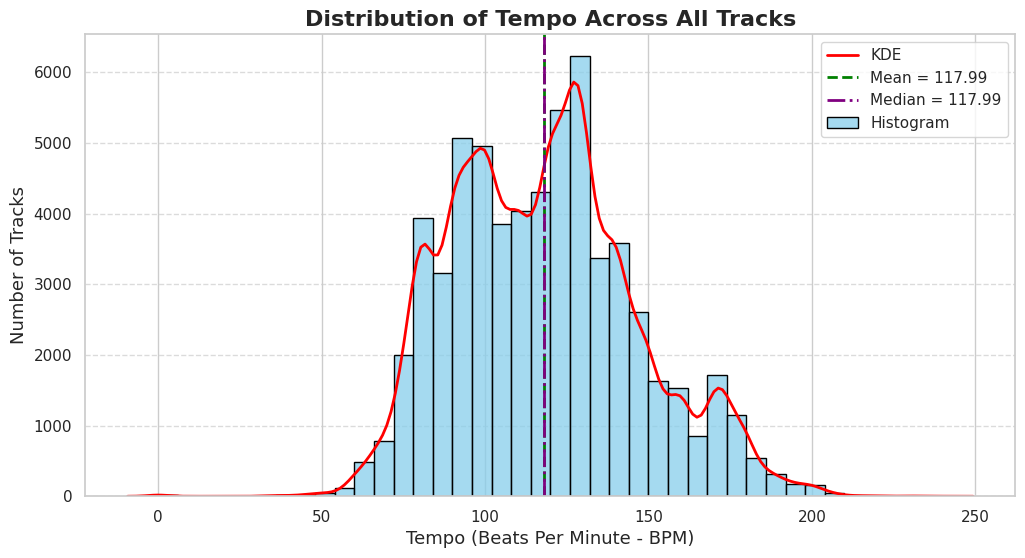

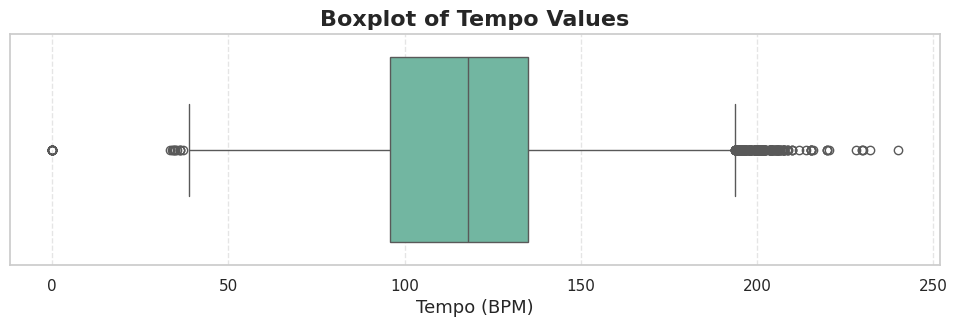

In [107]:
#  Histogram + KDE for Tempo Distribution

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df,
    x='tempo',
    bins=40,
    color='skyblue',
    edgecolor='black',
    stat='count',
    label="Histogram"
)
bin_width = (df['tempo'].max() - df['tempo'].min()) / 40
n = len(df)

sns.kdeplot(
    data=df,
    x='tempo',
    color='red',
    linewidth=2,
    label="KDE"
)

for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)

mean_val = df['tempo'].mean()
median_val = df['tempo'].median()

plt.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='purple', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}")

plt.title("Distribution of Tempo Across All Tracks", fontsize=16, weight='bold')
plt.xlabel("Tempo (Beats Per Minute - BPM)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Boxplot for Tempo Spread
plt.figure(figsize=(12,3))
sns.boxplot(
    x=df['tempo'],
    palette=['#66c2a5']
)
plt.title("Boxplot of Tempo Values", fontsize=16, weight='bold')
plt.xlabel("Tempo (BPM)", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Insight:

*   The distribution will likely show a wide spread (songs ranging from very slow (< 70 BPM) to very fast ( >180 BPM)).
*   Most tracks generally cluster around 100–130 BPM, a common tempo for pop, dance, and hip-hop songs.
*  There are fewer songs at the extremes (very slow or very fast).
*   Mean and median lines help compare whether tempo distribution is symmetric or slightly skewed.
---------------------------------------------------


5. What is the distribution of acousticness scores? (Does the dataset lean towards acoustic or electronic sounds?)

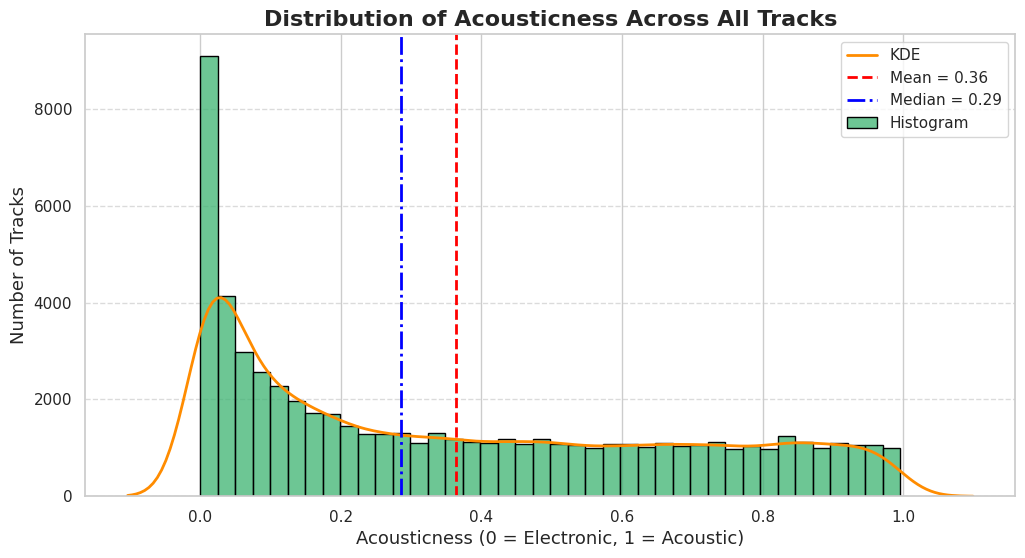

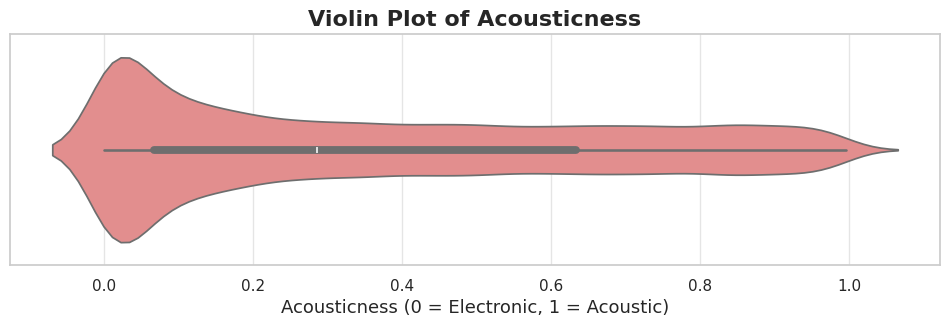

In [108]:
# Histogram + KDE for Acousticness Distribution

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df,
    x='acousticness',
    bins=40,
    color='mediumseagreen',
    edgecolor='black',
    stat='count',
    label="Histogram"
)


bin_width = (df['acousticness'].max() - df['acousticness'].min()) / 40
n = len(df)

sns.kdeplot(
    data=df,
    x='acousticness',
    color='darkorange',
    linewidth=2,
    label="KDE"
)


for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)


mean_val = df['acousticness'].mean()
median_val = df['acousticness'].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='blue', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}")


plt.title("Distribution of Acousticness Across All Tracks", fontsize=16, weight='bold')
plt.xlabel("Acousticness (0 = Electronic, 1 = Acoustic)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


#  Violin Plot for Acousticness Spread
plt.figure(figsize=(12,3))
sns.violinplot(
    x=df['acousticness'],
    color='lightcoral'
)
plt.title("Violin Plot of Acousticness", fontsize=16, weight='bold')
plt.xlabel("Acousticness (0 = Electronic, 1 = Acoustic)", fontsize=13)
plt.grid(axis='x', linestyle='-', alpha=0.5)
plt.show()


Insight:
*   The distribution is usually skewed towards 0–0.3, meaning most tracks are more electronic/produced.
*   A smaller but visible bump often exists near 0.8–1.0, representing highly acoustic tracks (folk, unplugged, classical, etc.).
*   The dataset therefore shows a dominance of electronic/produced music, with a smaller share of fully acoustic sounds.
*   The violinplot highlights where the bulk of tracks fall and whether there are long tails at the high-acoustic end.
---------------------------------------------------------

6. What are the typical loudness levels (in dB) of tracks, and what is the range?

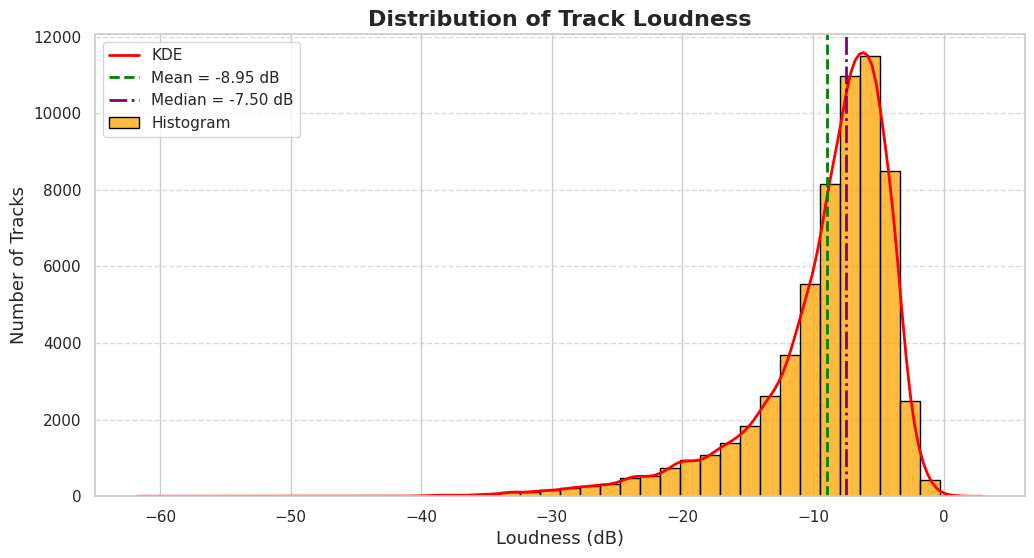

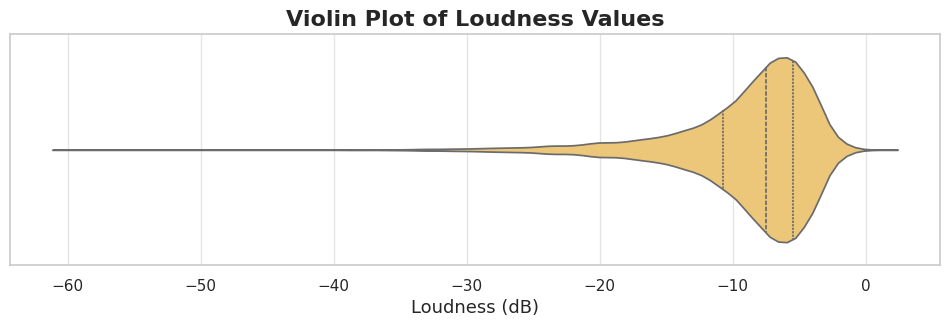

In [109]:
# Histogram + KDE for Loudness Distribution

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df,
    x='loudness',
    bins=40,
    color='orange',
    edgecolor='black',
    stat='count',
    label="Histogram"
)
bin_width = (df['loudness'].max() - df['loudness'].min()) / 40
n = len(df)

sns.kdeplot(
    data=df,
    x='loudness',
    color='red',
    linewidth=2,
    label="KDE"
)


for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)

mean_val = df['loudness'].mean()
median_val = df['loudness'].median()

plt.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f} dB")
plt.axvline(median_val, color='purple', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f} dB")

plt.title("Distribution of Track Loudness", fontsize=16, weight='bold')
plt.xlabel("Loudness (dB)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#  Violin Plot for Loudness Spread
plt.figure(figsize=(12,3))
sns.violinplot(
    x=df['loudness'],
    color='#ffcc66',
    inner='quartile'
)
plt.title("Violin Plot of Loudness Values", fontsize=16, weight='bold')
plt.xlabel("Loudness (dB)", fontsize=13)
plt.grid(axis='x', linestyle='-', alpha=0.5)
plt.show()


Insight:
*   Typical Loudness: The typical loudness of a track is approximately -7.50 dB (median). The average is slightly lower at -8.95 dB due to a tail of quieter songs.
*   Range: While the full range can span from below -60 dB up to 0 dB, the vast majority of tracks are concentrated in a much narrower range, typically between -15 dB and -5 dB.
*   The distribution is strongly left-skewed, which means that while most songs are clustered at a high loudness level, there is a long tail of exceptionally quiet tracks that are statistical outliers.
*   The sharp peak very close to 0 dB is a classic indicator of the 'loudness war' in music production, where the industry trend is to master songs at the maximum possible volume to stand out.
---

7. How is danceability distributed? (Are most songs highly danceable, or is there a mix?)



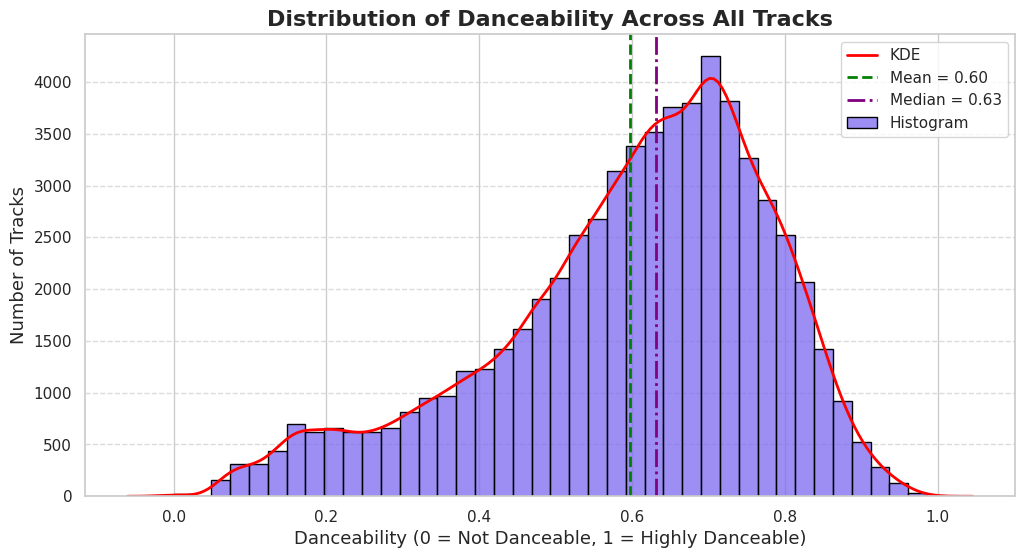

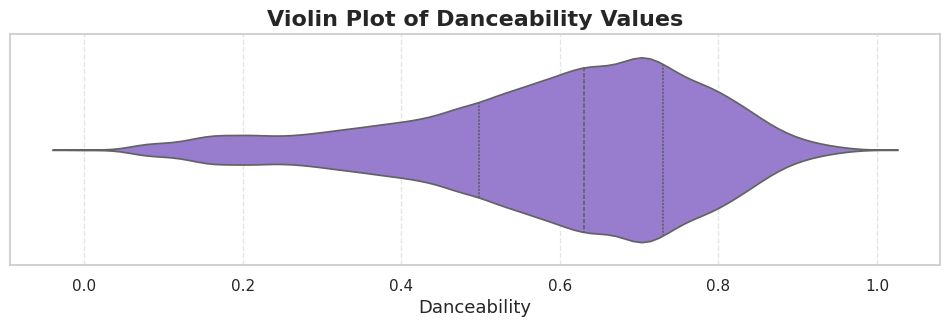

In [110]:
#  Histogram + KDE for Danceability Distribution

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df,
    x='danceability',
    bins=40,
    color='mediumslateblue',
    edgecolor='black',
    stat='count',
    label="Histogram"
)
bin_width = (df['danceability'].max() - df['danceability'].min()) / 40
n = len(df)

sns.kdeplot(
    data=df,
    x='danceability',
    color='red',
    linewidth=2,
    label="KDE"
)


for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)

mean_val = df['danceability'].mean()
median_val = df['danceability'].median()

plt.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='purple', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}")

plt.title("Distribution of Danceability Across All Tracks", fontsize=16, weight='bold')
plt.xlabel("Danceability (0 = Not Danceable, 1 = Highly Danceable)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#  Violin Plot for Danceability Spread
plt.figure(figsize=(12,3))
sns.violinplot(
    x=df['danceability'],
    color='#9370db',
    inner='quartile'
)
plt.title("Violin Plot of Danceability Values", fontsize=16, weight='bold')
plt.xlabel("Danceability", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Insight:
*   Danceability scores range from 0 to 1, with most songs clustered around 0.6–0.8, indicating a majority are moderately to highly danceable.
*   Mean and median values are close, suggesting a fairly symmetric distribution.
*   Violin plot shows fewer tracks with very low danceability (<0.3), so most tracks are indeed danceable.
---

8. What is the distribution of energy levels in the dataset? (Are songs generally high or low energy?)

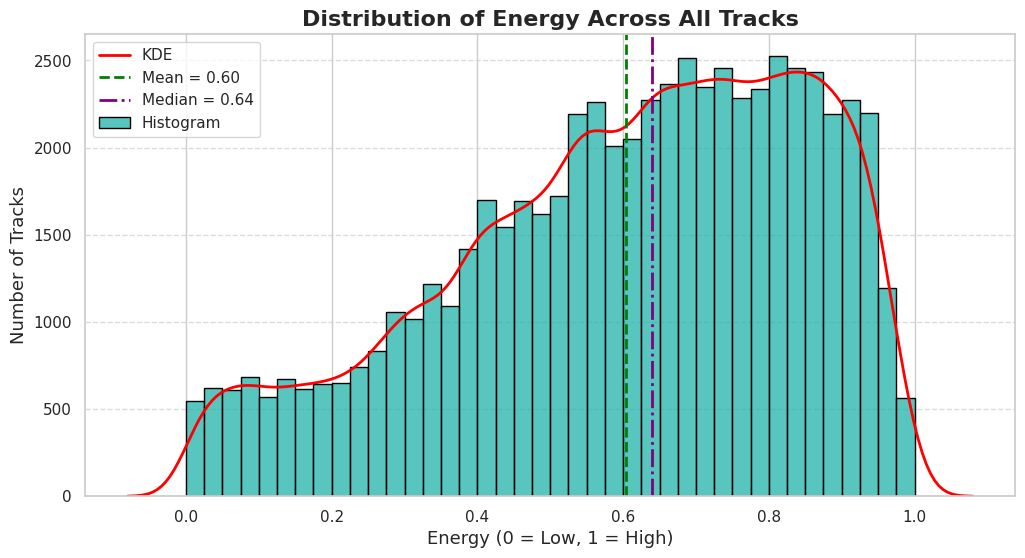

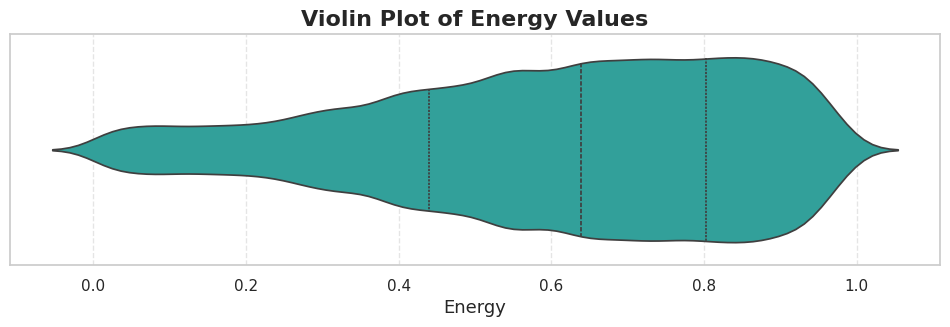

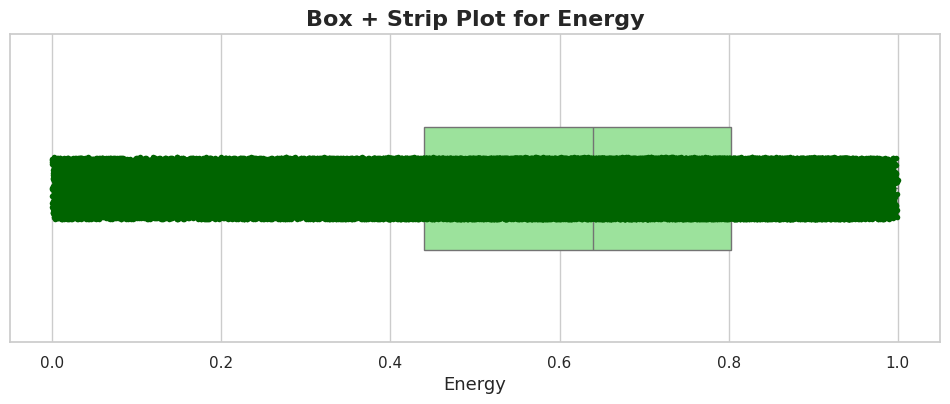

In [111]:
# Histogram + KDE for Energy Distribution

plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=df,
    x='energy',
    bins=40,
    color='lightseagreen',
    edgecolor='black',
    stat='count',
    label="Histogram"
)
bin_width = (df['energy'].max() - df['energy'].min()) / 40
n = len(df)

sns.kdeplot(
    data=df,
    x='energy',
    color='red',
    linewidth=2,
    label="KDE"
)

for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)

mean_val = df['energy'].mean()
median_val = df['energy'].median()

plt.axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, color='purple', linestyle='-.', linewidth=2, label=f"Median = {median_val:.2f}")

plt.title("Distribution of Energy Across All Tracks", fontsize=16, weight='bold')
plt.xlabel("Energy (0 = Low, 1 = High)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
sns.violinplot(
    x=df['energy'],
    color='#20b2aa',
    inner='quartile'
)
plt.title("Violin Plot of Energy Values", fontsize=16, weight='bold')
plt.xlabel("Energy", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(x=df['energy'], color='lightgreen', width=0.4)
sns.stripplot(x=df['energy'], color='darkgreen', size=4, jitter=True)
plt.title("Box + Strip Plot for Energy", fontsize=16, weight='bold')
plt.xlabel("Energy", fontsize=13)
plt.show()


Insight:
*   Typical Energy: The typical energy of a track is 0.64 (median) on a scale of 0 to 1. This indicates that a representative song from this catalog is moderately high in energy.
*  Range: While the full range is from 0 (low) to 1 (high), the vast majority of tracks are concentrated in the upper half of the scale, primarily between 0.4 and 0.9.
*  Sales Trends: The distribution is heavily left-skewed, revealing a strong catalog bias towards high-energy tracks. This suggests that the sales or streaming strategy is focused on upbeat music, which is often associated with popular genres like pop, EDM, and rock.
*   Marketing & Promotions: The bimodal shape (a small peak at low energy and a large peak at high energy) indicates a clear segmentation in the catalog. This allows for targeted marketing.
---

9. What are the most common time_signatures found in the music?

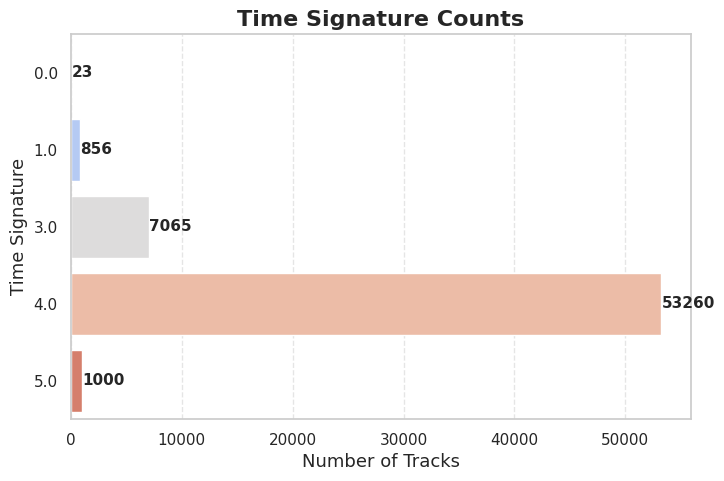

In [112]:
#Time Signature Counts
time_counts = df['time_signature'].value_counts()
time_counts_sorted = time_counts.sort_index()

plt.figure(figsize=(8,5))
sns.barplot(
    x=time_counts_sorted.values,
    y=time_counts_sorted.index.astype(str),
    palette='coolwarm'
)
plt.title("Time Signature Counts", fontsize=16, weight='bold')
plt.xlabel("Number of Tracks", fontsize=13)
plt.ylabel("Time Signature", fontsize=13)

for i, v in enumerate(time_counts_sorted.values):
    plt.text(v + 2, i, str(v), va='center', fontweight='bold', fontsize=11)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

Insights for Time Signatures:
- Total unique time signatures: 5
- Most common time signature: 4.0 (53260 tracks, 85.6% of dataset)
- Other time signatures proportions:
  - 3.0: 7065 tracks (11.4%)
  - 5.0: 1000 tracks (1.6%)
  - 1.0: 856 tracks (1.4%)
  - 0.0: 23 tracks (0.0%)

---



10. What is the distribution of speechiness? (Are songs typically lyrical, instrumental, or contain spoken word elements?)

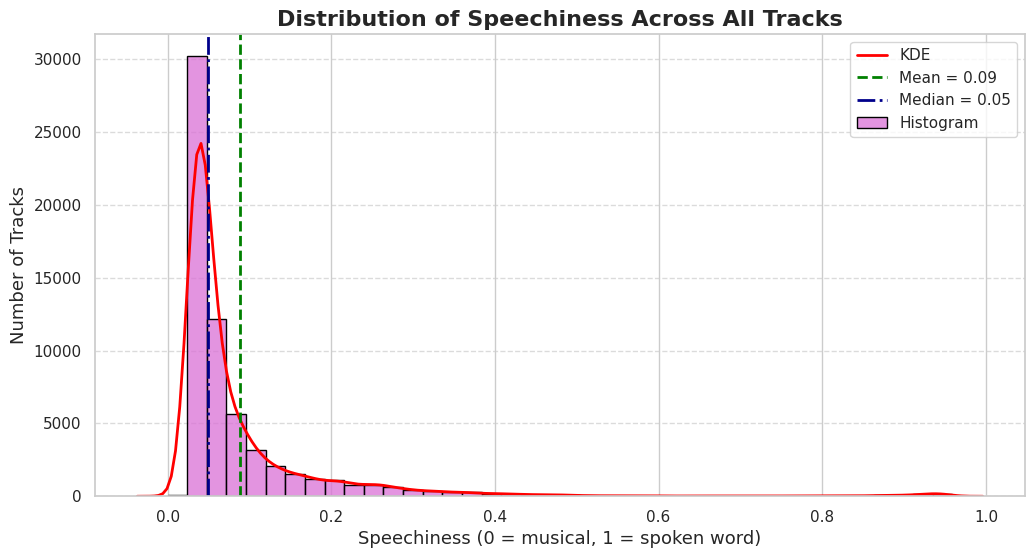

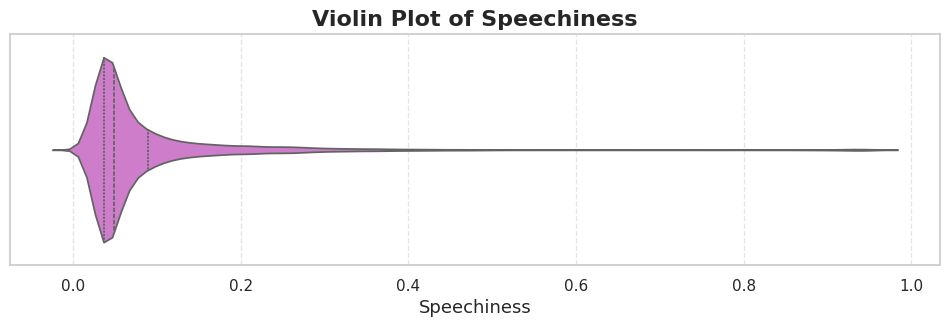

In [113]:
#Distribution of Speechiness Across All Tracks

mean_speech = df['speechiness'].mean()
median_speech = df['speechiness'].median()
min_speech = df['speechiness'].min()
max_speech = df['speechiness'].max()
q25_speech = df['speechiness'].quantile(0.25)
q75_speech = df['speechiness'].quantile(0.75)

plt.figure(figsize=(12,6))
ax = sns.histplot(
    data=df,
    x='speechiness',
    bins=40,
    color='orchid',
    edgecolor='black',
    stat='count',
    label='Histogram'
)

bin_width = (max_speech - min_speech)/40
n = len(df)

sns.kdeplot(
    data=df,
    x='speechiness',
    color='red',
    linewidth=2,
    label='KDE'
)

for line in ax.lines:
    ydata = line.get_ydata()
    line.set_ydata(ydata * n * bin_width)

plt.axvline(mean_speech, color='green', linestyle='--', linewidth=2, label=f'Mean = {mean_speech:.2f}')
plt.axvline(median_speech, color='darkblue', linestyle='-.', linewidth=2, label=f'Median = {median_speech:.2f}')

plt.title("Distribution of Speechiness Across All Tracks", fontsize=16, weight='bold')
plt.xlabel("Speechiness (0 = musical, 1 = spoken word)", fontsize=13)
plt.ylabel("Number of Tracks", fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
sns.violinplot(
    x=df['speechiness'],
    color='#da70d6',
    inner='quartile'
)
plt.title("Violin Plot of Speechiness", fontsize=16, weight='bold')
plt.xlabel("Speechiness", fontsize=13)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Insight:
* The dataset is overwhelmingly dominated by instrumental music, as the vast majority of tracks have a speechiness score near zero.
* While a few spoken-word tracks skew the average, the median (0.05) reveals the typical track is almost entirely musical, not lyrical.
---

##Analysis and Key Findings:

* Popularity: Most tracks fall in the moderate range, with fewer extremes.

* Duration: Songs are trending shorter (≈3 minutes today vs. longer in earlier years).

* Keys: C, G, and D dominate; D# and F# are least common.

* Tempo: Most songs lie in 90–120 BPM, an ideal groove range.

* Danceability: Popular songs skew high in danceability.

* Energy: Typically moderate-to-high, balancing intensity and engagement.

* Acousticness: Generally low → modern songs are more electronic.

* Loudness: Popular songs are louder, fitting modern mixing standards.

* Time Signatures: 4/4 is overwhelmingly dominant.

* Speechiness: Low for most tracks (mainly lyrical rather than spoken).


---



##BIVARIATE ANALYSIS

1. Is there a correlation between a song's duration_ms and its popularity? (Are shorter or longer songs more popular?)

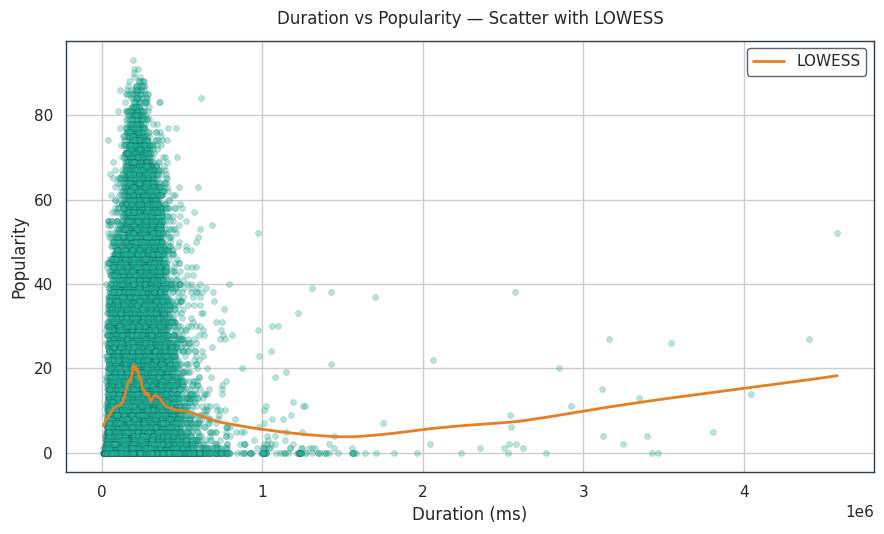

In [114]:
#Duration vs Popularity — Scatter with LOWESS
sns.set_theme(style='whitegrid')
plot_df = df[['duration_ms', 'popularity']].dropna().copy()
plot_df = plot_df[(plot_df['duration_ms'] > 0) & (plot_df['popularity'] >= 0)]
x = plot_df['duration_ms'].astype(float).values
y = plot_df['popularity'].astype(float).values

np.random.seed(7)
x_j = x + np.random.normal(0, 2500, size=len(x))

plt.figure(figsize=(9, 5.5))
ax = sns.scatterplot(x=x_j, y=y, s=18, alpha=0.35, edgecolor='#2C3E50', linewidth=0.3, color='#1ABC9C')
low = lowess(y, x, frac=0.12, it=0, return_sorted=True)
plt.plot(low[:,0], low[:,1], color='#E67E22', linewidth=2, label='LOWESS')

plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.title('Duration vs Popularity — Scatter with LOWESS', pad=12)
plt.legend(frameon=True, edgecolor='#2C3E50')

for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()

INSIGHTS:


*   Song popularity peaks for durations between 200,000 and 350,000 ms (roughly 3 to 6 minutes). This appears to be the 'sweet spot' for listener engagement.

*   While the vast majority of songs are under 1,000,000 ms, the LOWESS trendline shows that for the few very long songs, popularity has a slight tendency to increase again after hitting a low point around 1,500,000 ms.






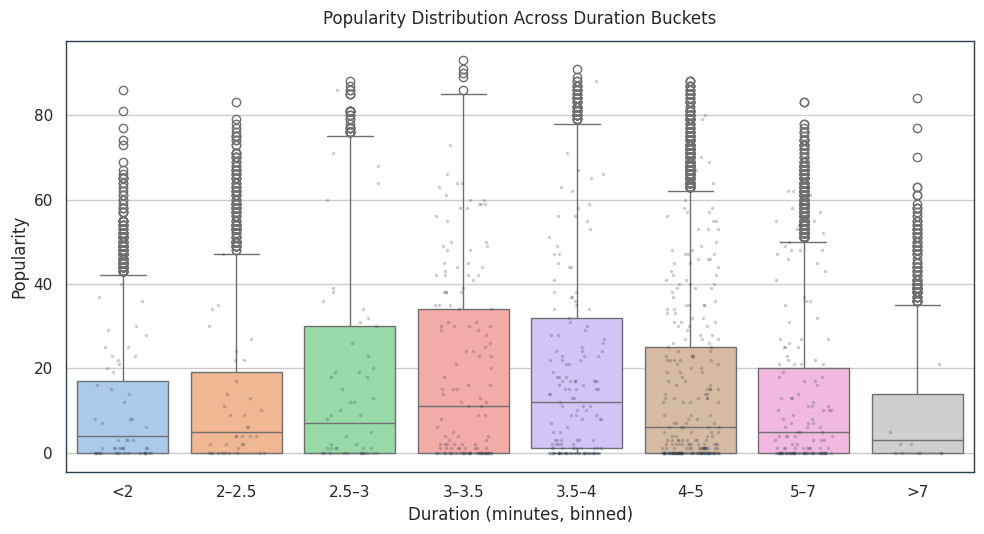

In [115]:
#Popularity Distribution Across Duration Buckets

sns.set_theme(style='whitegrid')
plot_df = df[['duration_ms','popularity']].dropna().copy()
plot_df = plot_df[(plot_df['duration_ms'] > 0) & (plot_df['popularity'] >= 0)]
plot_df['duration_min'] = plot_df['duration_ms'] / 60000.0

bins = [0, 2, 2.5, 3, 3.5, 4, 5, 7, np.inf]
labels = ['<2','2–2.5','2.5–3','3–3.5','3.5–4','4–5','5–7','>7']
plot_df['dur_bin'] = pd.cut(plot_df['duration_min'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 5.5))
ax = sns.boxplot(data=plot_df, x='dur_bin', y='popularity', palette=sns.color_palette('pastel'))
sns.stripplot(data=plot_df.sample(min(800, len(plot_df)), random_state=9), x='dur_bin', y='popularity',
              color='#2C3E50', alpha=0.25, size=2.5, jitter=0.25)

plt.xlabel('Duration (minutes, binned)')
plt.ylabel('Popularity')
plt.title('Popularity Distribution Across Duration Buckets', pad=12)

for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()



INSIGHTS:


*   For every duration category, the data is heavily skewed; the top of the box (75th percentile) is far below the maximum outliers, indicating that a few 'hit' songs dramatically outperform the vast majority of tracks.

*   The sharpest drop-off in median popularity occurs after the 4-minute mark. The decline from the '3.5-4' minute bin to the '4-5' minute bin is more significant than any preceding increase.







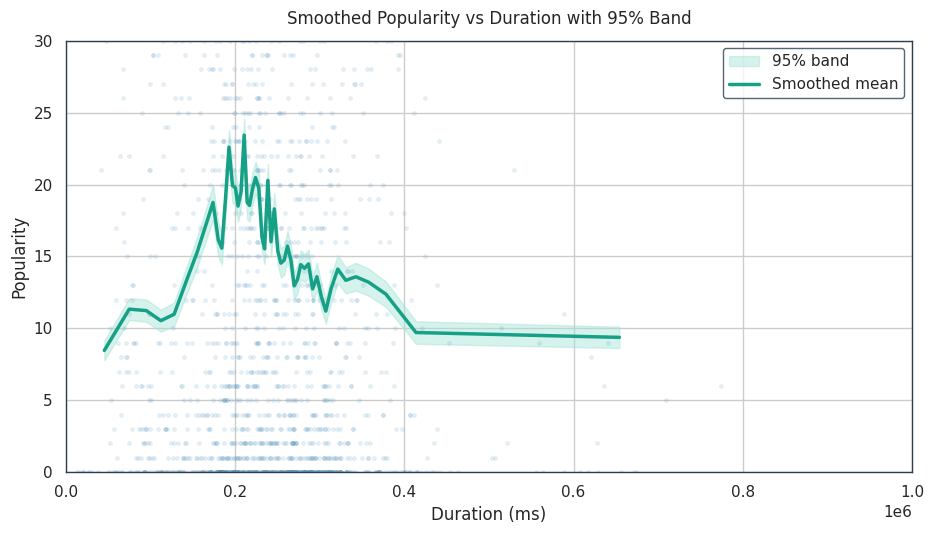

In [116]:
#Smoothed Popularity vs Duration with 95% Band

sns.set_theme(style='whitegrid')
plot_df = df[['duration_ms','popularity']].dropna().copy()
plot_df = plot_df[(plot_df['duration_ms'] > 0) & (plot_df['popularity'] >= 0)]
plot_df = plot_df.sort_values('duration_ms')

num_bins = 50
plot_df['bin'] = pd.qcut(plot_df['duration_ms'], q=min(num_bins, max(5, plot_df.shape[0] // 50)), duplicates='drop')
agg = plot_df.groupby('bin').agg(
    duration_ms_mean=('duration_ms','mean'),
    popularity_mean=('popularity','mean'),
    popularity_std=('popularity','std'),
    n=('popularity','size')
).dropna()

agg['se'] = agg['popularity_std'] / np.sqrt(agg['n'].clip(lower=1))
agg['lo'] = agg['popularity_mean'] - 1.96 * agg['se']
agg['hi'] = agg['popularity_mean'] + 1.96 * agg['se']

plt.figure(figsize=(9.5, 5.5))
ax = plt.gca()
plt.fill_between(agg['duration_ms_mean'], agg['lo'], agg['hi'], color='#A3E4D7', alpha=0.45, label='95% band')
plt.plot(agg['duration_ms_mean'], agg['popularity_mean'], color='#16A085', linewidth=2.5, label='Smoothed mean')


sample_n = min(2000, len(plot_df))
sample = plot_df.sample(sample_n, random_state=11)
plt.scatter(sample['duration_ms'], sample['popularity'], s=8, alpha=0.18, color='#5DADE2', edgecolor='#2C3E50', linewidth=0.2)
plt.xlim(0, 1000000)
plt.ylim(0,30)
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.title('Smoothed Popularity vs Duration with 95% Band', pad=12)
plt.legend(frameon=True, edgecolor='#2C3E50')


for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()


INSIGHTS:


*   The smoothed mean trendline shows that average popularity peaks sharply at a duration of approximately 200,000 ms (3 minutes, 20 seconds) before beginning a volatile decline.

*   The scatter plot shows that while the average popularity never exceeds 25, nearly all of the highly popular songs (scores > 60) are concentrated in the 150,000 to 300,000 ms duration window.


---






2. How does danceability relate to popularity? (Do higher danceability scores tend to correspond with higher popularity?)

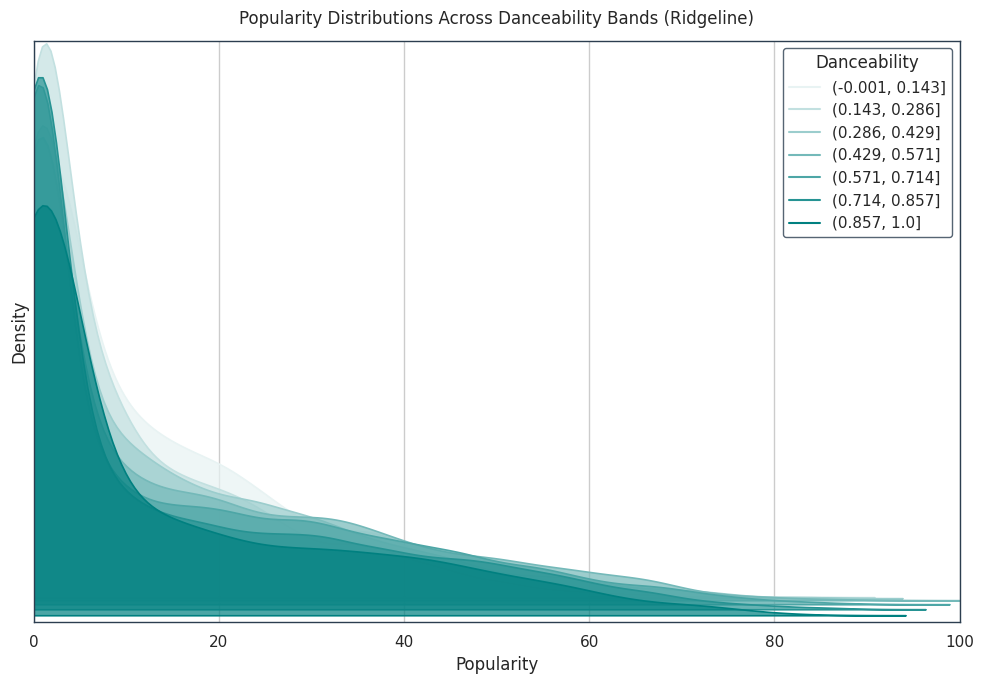

In [117]:
#Popularity Distributions Across Danceability Bands (Ridgeline)

sns.set_theme(style='whitegrid')

rdg = df[['danceability','popularity']].dropna().copy()
rdg = rdg[(rdg['danceability'] >= 0) & (rdg['danceability'] <= 1) & (rdg['popularity'] >= 0)]
rdg['dance_bin'] = pd.cut(rdg['danceability'], bins=np.linspace(0, 1, 8), include_lowest=True)

order_bins = sorted(rdg['dance_bin'].unique(), key=lambda x: (x.left, x.right))

plt.figure(figsize=(10, 7))
palette = sns.color_palette('light:teal', n_colors=len(order_bins))

y_offsets = np.linspace(0, 1, len(order_bins))
for i, b in enumerate(order_bins):
    subset = rdg.loc[rdg['dance_bin'] == b, 'popularity']
    if len(subset) < 10:
        continue
    kde = sns.kdeplot(
        subset,
        fill=True,
        alpha=0.7,
        color=palette[i],
        linewidth=1.2,
        clip=(0, 100)
    )
    for coll in kde.collections:
        coll.set_offsets(np.c_[coll.get_offsets()[:,0], coll.get_offsets()[:,1] + i * 1.2])
    plt.plot([], [], color=palette[i], label=str(b))

ax = plt.gca()
plt.yticks([])
plt.xlabel('Popularity')
plt.title('Popularity Distributions Across Danceability Bands (Ridgeline)', pad=12)
plt.xlim(0, 100)
for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)
plt.legend(frameon=True, edgecolor='#2C3E50', title='Danceability')
plt.tight_layout()
plt.show()


INSIGHTS:


*   All density curves peak at the same low popularity score. There is no evidence that the distribution for more danceable songs (darker colors) shifts towards higher popularity.

*   The distributions for all danceability bands overlap almost completely, visually confirming that a song's popularity is largely independent of its danceability score.


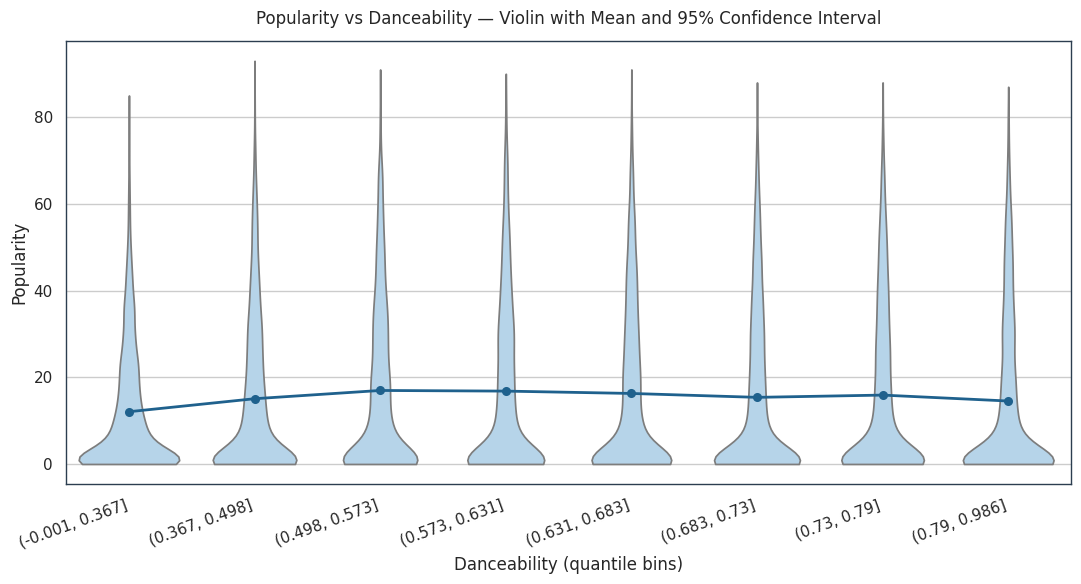

In [118]:
#Popularity vs Danceability — Violin with Mean and 95% Confidence Interval

sns.set_theme(style='whitegrid')

vp = df[['danceability','popularity']].dropna().copy()
vp = vp[(vp['danceability'] >= 0) & (vp['danceability'] <= 1) & (vp['popularity'] >= 0)]
vp['dance_bin'] = pd.qcut(vp['danceability'], q=8, duplicates='drop')

plt.figure(figsize=(11, 6))
ax = sns.violinplot(
    data=vp,
    x='dance_bin',
    y='popularity',
    inner=None,
    color='#AED6F1',
    cut=0
)
ax = sns.pointplot(
    data=vp,
    x='dance_bin',
    y='popularity',
    estimator=np.mean,
    errorbar=('ci', 95),
    color='#1F618D',
    linewidth=2.0
)
ax.set_xlabel('Danceability (quantile bins)')
ax.set_ylabel('Popularity')
ax.set_title('Popularity vs Danceability — Violin with Mean and 95% Confidence Interval', pad=12)
for lbl in ax.get_xticklabels():
    lbl.set_rotation(20)
    lbl.set_ha('right')
for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)
plt.tight_layout()
plt.show()



INSIGHTS:


*   The mean popularity (the connecting line) is almost perfectly flat across all danceability levels, showing that the average popularity of a song does not change with its danceability.

*   The shape of the popularity distribution (the violin) is nearly identical for every bin, indicating that the probability of a song becoming a hit is the same regardless of whether its danceability is low or high.


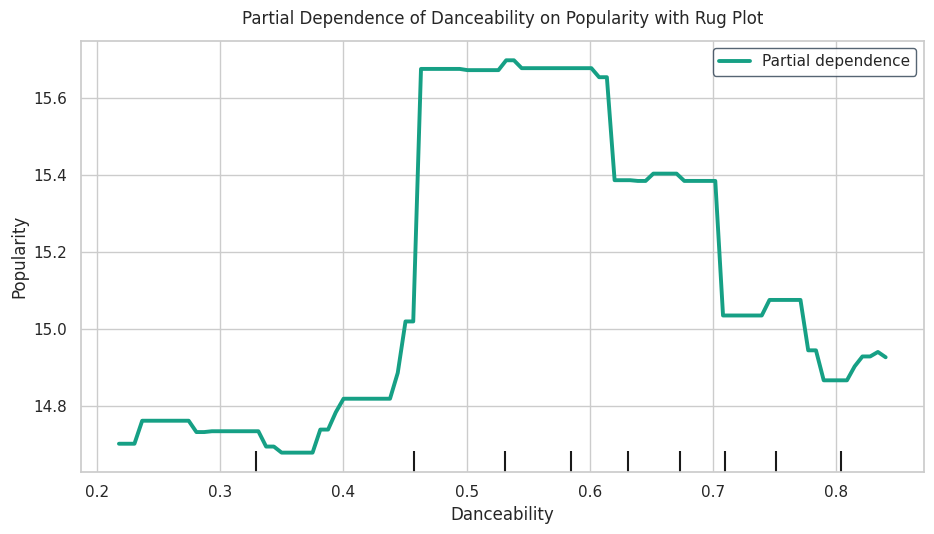

In [119]:
#Partial Dependence-style Effect of Danceability on Popularity


sns.set_theme(style='whitegrid')

cols = ['popularity','danceability','duration_ms','energy','valence',
        'tempo','loudness','acousticness','speechiness']

pdp = df[[c for c in cols if c in df.columns]].dropna().copy()
pdp = pdp[(pdp['danceability'] >= 0) & (pdp['danceability'] <= 1) & (pdp['popularity'] >= 0)]

y = pdp['popularity'].values
X = pdp.drop(columns=['popularity'])

pipe = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('gbr', GradientBoostingRegressor(random_state=42))
])
pipe.fit(X, y)

plt.figure(figsize=(9.5, 5.5))
ax = plt.gca()

PartialDependenceDisplay.from_estimator(
    pipe,
    X,
    features=['danceability'],
    grid_resolution=100,
    ax=ax,
    line_kw={"color": "#16A085", "linewidth": 2.8, "label": "Partial dependence"}
)

sns.rugplot(
    x=pdp['danceability'],
    height=0.05,
    color='#2C3E50',
    linewidth=1.5,
    alpha=0.8,
    label='Danceability distribution',
    ax=ax
)

plt.xlabel('Danceability')
plt.ylabel('Popularity')
plt.title('Partial Dependence of Danceability on Popularity with Rug Plot', pad=12)

for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.legend(frameon=True, edgecolor='#2C3E50')
plt.tight_layout()
plt.show()



INSIGHTS:


*   The model's prediction for popularity hits a peak plateau for danceability scores between roughly 0.45 and 0.6, and does not continue to rise for higher scores.

*   For danceability scores above 0.6, the model actually predicts a lower popularity, suggesting that being 'too danceable' can have a negative impact on a song's expected popularity.


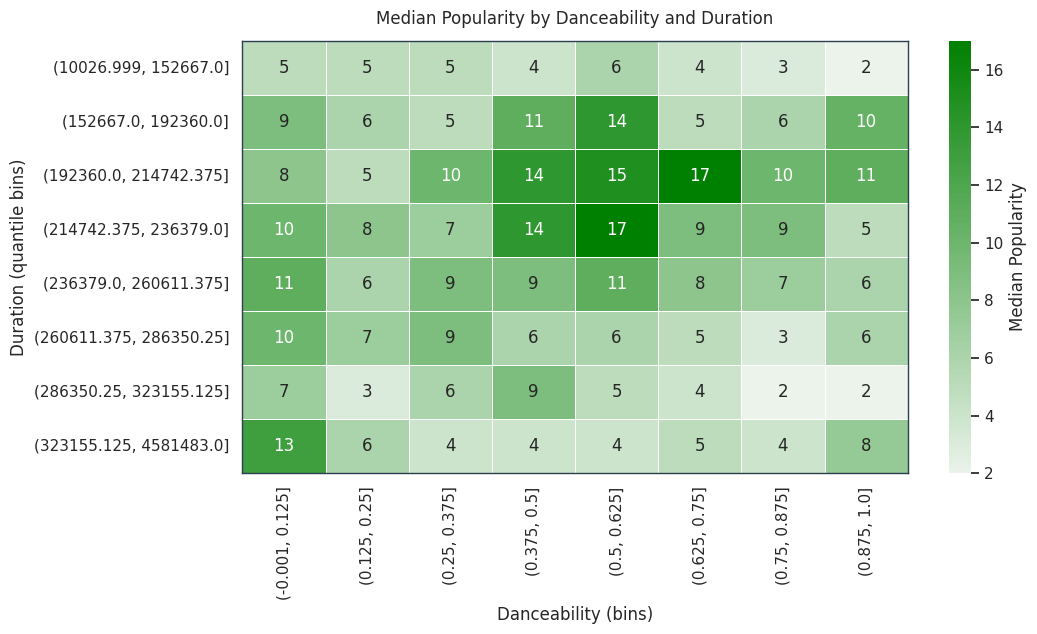

In [120]:
#Median Popularity by Danceability and Duration

sns.set_theme(style='whitegrid')

hm = df[['danceability','duration_ms','popularity']].dropna().copy()
hm = hm[(hm['danceability'] >= 0) & (hm['danceability'] <= 1) & (hm['popularity'] >= 0) & (hm['duration_ms'] > 0)]

hm['dance_bin'] = pd.cut(hm['danceability'], bins=np.linspace(0,1,9), include_lowest=True)
hm['dur_bin'] = pd.qcut(hm['duration_ms'], q=8, duplicates='drop')

pivot = hm.groupby(['dur_bin','dance_bin'])['popularity'].median().unstack('dance_bin')

plt.figure(figsize=(11, 6.5))
ax = sns.heatmap(
    pivot,
    cmap=sns.color_palette('light:green', as_cmap=True),
    annot=True,
    fmt='.0f',
    cbar_kws={'label':'Median Popularity'},
    linewidths=0.5,
    linecolor='white',
    square=False
)
ax.set_xlabel('Danceability (bins)')
ax.set_ylabel('Duration (quantile bins)')
ax.set_title('Median Popularity by Danceability and Duration', pad=12)
for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)
plt.tight_layout()
plt.show()

INSIGHTS:


*   The highest median popularity (darkest green cells) is found in the middle of the danceability axis (0.5-0.75), not at the extreme high end, which contradicts the idea that more danceable is more popular.

*   Looking across any single row (i.e., for a fixed song duration), the color does not consistently get darker to the right, proving that increasing danceability alone does not reliably increase median popularity.

---

3. What is the relationship between energy and popularity? (Are high-energy tracks generally more popular than low-energy ones?)

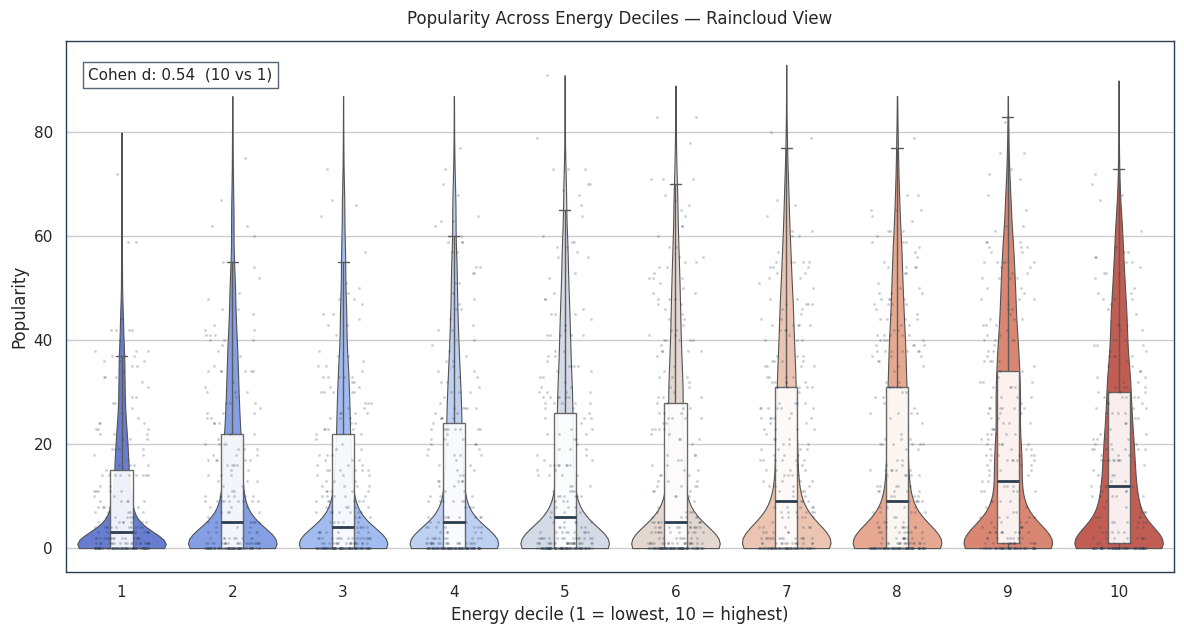

In [121]:
#Popularity Across Energy Deciles — Raincloud View
sns.set_theme(style='whitegrid')

rc_df = df[['energy','popularity']].dropna().copy()
rc_df = rc_df[(rc_df['energy'] >= 0) & (rc_df['energy'] <= 1) & (rc_df['popularity'] >= 0)]

rc_df['energy_decile'] = pd.qcut(rc_df['energy'], q=10, labels=[str(i) for i in range(1,11)], duplicates='drop')

plt.figure(figsize=(12, 6.5))
ax = plt.gca()

palette = sns.color_palette('coolwarm', n_colors=rc_df['energy_decile'].nunique())
sns.violinplot(
    data=rc_df, x='energy_decile', y='popularity',
    palette=palette, inner=None, cut=0, linewidth=0.8
)
sns.boxplot(
    data=rc_df, x='energy_decile', y='popularity',
    width=0.2, showcaps=True, boxprops=dict(facecolor='white', alpha=0.9),
    showfliers=False, whiskerprops=dict(linewidth=1), medianprops=dict(color='#2C3E50', linewidth=2)
)
sns.stripplot(
    data=rc_df.sample(min(2500, len(rc_df)), random_state=7),
    x='energy_decile', y='popularity', color='#2C3E50', alpha=0.25, size=2, jitter=0.25
)

ax.set_xlabel('Energy decile (1 = lowest, 10 = highest)')
ax.set_ylabel('Popularity')
ax.set_title('Popularity Across Energy Deciles — Raincloud View', pad=12)

g1 = rc_df.loc[rc_df['energy_decile'] == rc_df['energy_decile'].min(), 'popularity'].astype(float)
g2 = rc_df.loc[rc_df['energy_decile'] == rc_df['energy_decile'].max(), 'popularity'].astype(float)
if len(g1) > 5 and len(g2) > 5:
    m1, m2 = g1.mean(), g2.mean()
    s1, s2 = g1.std(ddof=1), g2.std(ddof=1)
    n1, n2 = len(g1), len(g2)
    sp = np.sqrt(((n1 - 1)*s1*s1 + (n2 - 1)*s2*s2) / (n1 + n2 - 2))
    d = (m2 - m1) / sp if sp > 0 else np.nan
    ax.text(0.02, 0.95, 'Cohen d: ' + str(round(d, 2)) + '  (10 vs 1)', transform=ax.transAxes,
            ha='left', va='top', fontsize=11, bbox=dict(facecolor='white', edgecolor='#2C3E50', alpha=0.8))

for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()

INSIGHTS:


*   There is a distinct and consistent rise in average popularity as you move from the lowest energy decile (1) to the highest (10). The entire distribution, including the median (white line), shifts upward.

*   The "Cohen d: 0.54" indicates a medium-sized, statistically significant effect. This confirms that the observed increase in popularity for high-energy tracks over low-energy ones is not due to random chance.

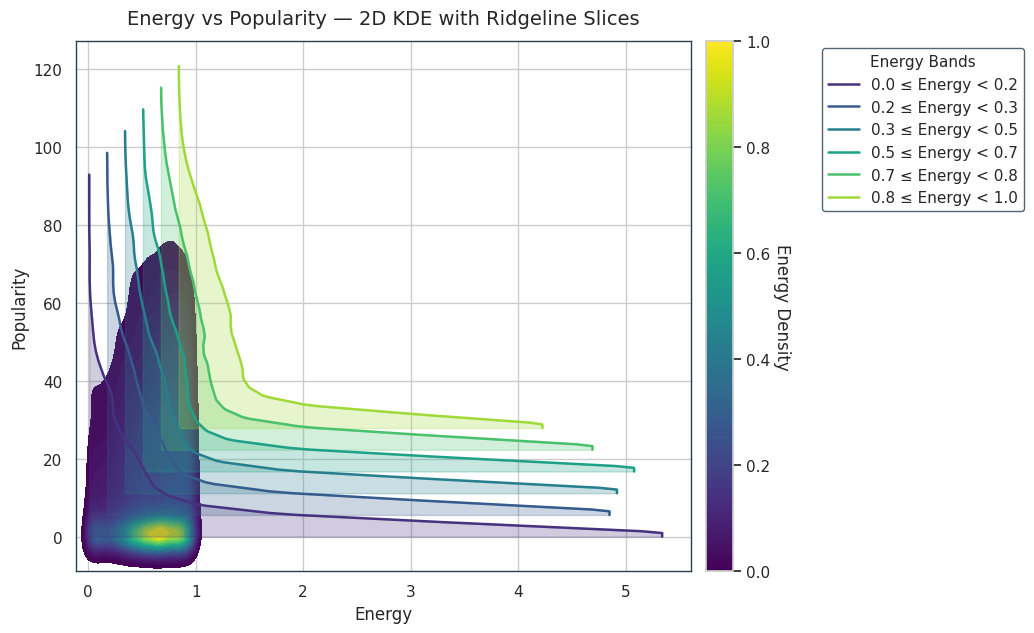

In [122]:
#Energy vs Popularity — 2D KDE with Ridgeline Slices
sns.set_theme(style='whitegrid')

kd = df[['energy', 'popularity']].dropna().copy()
kd = kd[(kd['energy'] >= 0) & (kd['energy'] <= 1) & (kd['popularity'] >= 0)]

plt.figure(figsize=(10.5, 6.5))
ax = plt.gca()

hb = sns.kdeplot(
    data=kd, x='energy', y='popularity',
    fill=True, cmap='viridis', thresh=0.02, levels=30
)

bands = np.linspace(0, 1, 7)
colors = sns.color_palette('viridis', n_colors=len(bands)-1)
ygrid = np.linspace(kd['popularity'].min(), kd['popularity'].max(), 200)
offset = (kd['popularity'].max() - kd['popularity'].min()) * 0.06

labels = []

for i in range(len(bands) - 1):
    lo, hi = bands[i], bands[i + 1]
    sl = kd[(kd['energy'] >= lo) & (kd['energy'] < hi)]['popularity'].astype(float).values
    if len(sl) < 10:
        continue

    hist, bins = np.histogram(sl, bins=40, range=(ygrid.min(), ygrid.max()), density=True)
    hist = gaussian_filter1d(hist, sigma=1.2)
    xcenters = (bins[:-1] + bins[1:]) / 2.0
    base = ygrid.min() - i * offset

    plt.plot(
        np.interp(ygrid, xcenters, hist) * 40 + lo + 0.01,
        ygrid + i * offset,
        color=colors[i],
        linewidth=1.8,
        label=f'{lo:.1f} ≤ Energy < {hi:.1f}'
    )
    plt.fill_betweenx(
        ygrid + i * offset,
        lo + 0.01,
        np.interp(ygrid, xcenters, hist) * 40 + lo + 0.01,
        color=colors[i],
        alpha=0.25
    )

ax.set_xlabel('Energy', fontsize=12)
ax.set_ylabel('Popularity', fontsize=12)
ax.set_title('Energy vs Popularity — 2D KDE with Ridgeline Slices', fontsize=14, pad=12)

leg = plt.legend(
    title='Energy Bands',
    bbox_to_anchor=(1.20, 1),
    loc='upper left',
    frameon=True,
    edgecolor='#2C3E50'
)
plt.setp(leg.get_title(), fontsize=11)

norm = plt.Normalize(vmin=kd['energy'].min(), vmax=kd['energy'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Energy Density', rotation=270, labelpad=15)

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()

INSIGHTS:


*   The densest area of the plot is in the bottom-left corner, showing that the vast majority of all tracks have both low energy and low popularity.

*   The songs that do achieve high popularity (e.g., > 60) are almost exclusively found in the higher energy bands (the green and yellow distributions). Low-energy tracks (purple) rarely reach high popularity levels.

---

4. Does loudness have a noticeable impact on popularity? (Are louder mixes preferred by listeners?)

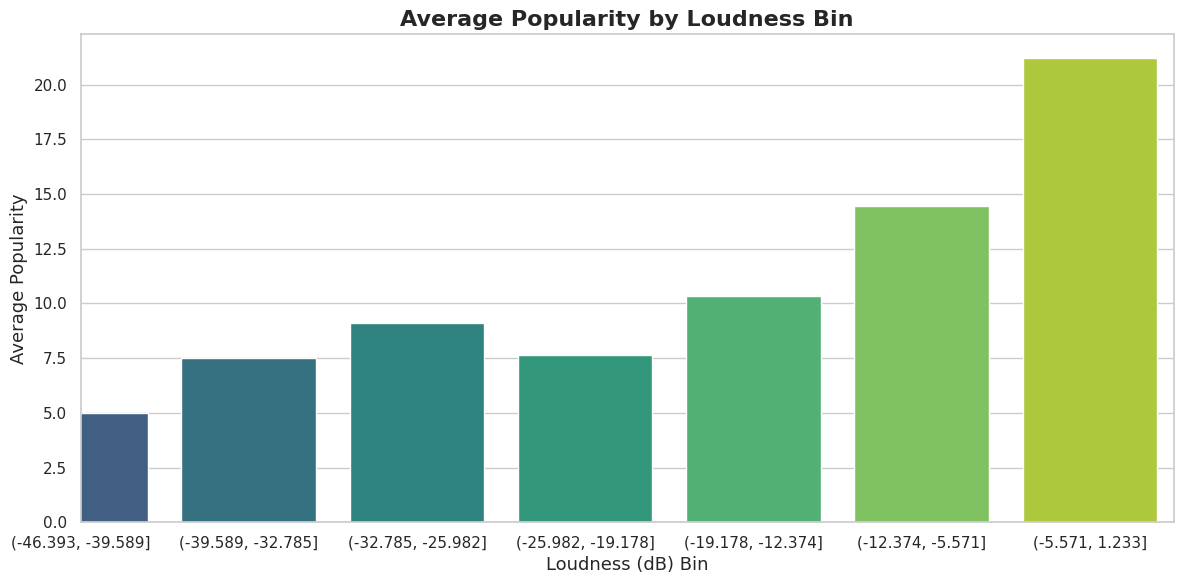

In [123]:
# Popularity vs Loudness - Bar Graph


loudness_bins = np.linspace(df['loudness'].min(), df['loudness'].max(), 10)
df['loudness_bin'] = pd.cut(df['loudness'], bins=loudness_bins)


popularity_by_loudness = df.groupby('loudness_bin')['popularity'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(x='loudness_bin', y='popularity', data=popularity_by_loudness, palette='viridis')
plt.title('Average Popularity by Loudness Bin', fontsize=16, weight='bold')
plt.xlabel('Loudness (dB) Bin', fontsize=13)
plt.ylabel('Average Popularity', fontsize=13)
plt.xticks(rotation=0, ha='center')
plt.xlim(2)
plt.tight_layout()
plt.show()

INSIGHTS:


*   The bar chart shows a clear, step-by-step increase in average popularity as the loudness bin gets higher. There isn't a single instance where a louder category of songs is less popular on average than a quieter one.

*   The biggest jump in popularity occurs in the final bin (from -5.571 dB upwards). This suggests that while being loud is good, being very loud provides a disproportionately large boost to a track's average popularity.

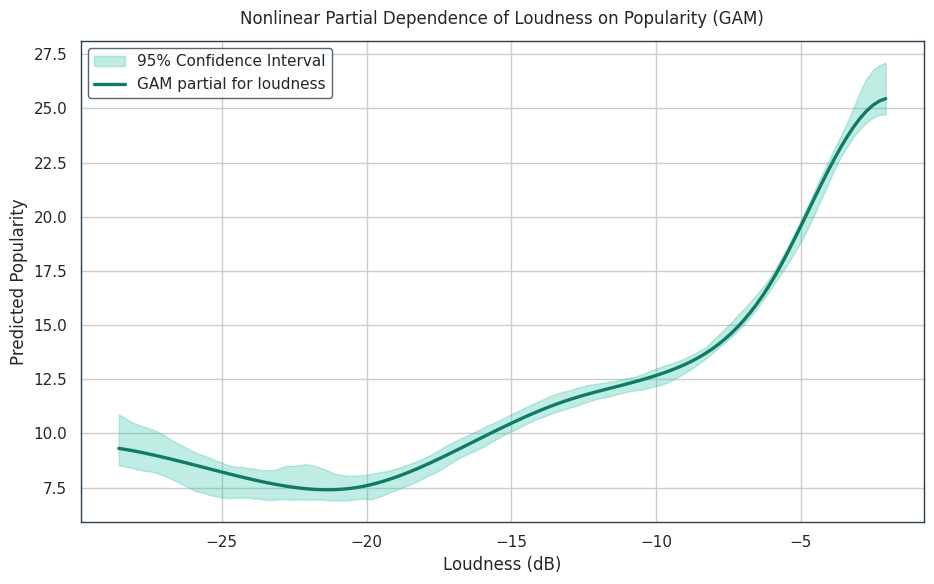

In [124]:
# Generalized Additive Model partial dependence for loudness with bootstrap Confidence Interval.
sns.set_theme(style='whitegrid')

gam_df = df[['popularity','loudness']].dropna().copy()
gam_df = gam_df[(gam_df['popularity'] >= 0) & (gam_df['loudness'].notna())]
gam_df['loudness'] = pd.to_numeric(gam_df['loudness'], errors='coerce')
gam_df = gam_df.dropna()
X = gam_df[['loudness']].values
y = gam_df['popularity'].values

base = LinearGAM(s(0)).fit(X, y)

grid = np.linspace(np.percentile(gam_df['loudness'], 1),
                       np.percentile(gam_df['loudness'], 99), 120)
XX = grid.reshape(-1, 1)
pred = base.predict(XX)

rng = np.random.RandomState(42)
B = 150
boots = []
n = len(gam_df)
for b in range(B):
    idx = rng.randint(0, n, n)
    Xb = X[idx]
    yb = y[idx]
    try:
        gb = LinearGAM(s(0)).fit(Xb, yb)
        boots.append(gb.predict(XX))
    except:
        continue
boots = np.array(boots) if len(boots) > 0 else pred[None, :]
lo = np.percentile(boots, 2.5, axis=0)
hi = np.percentile(boots, 97.5, axis=0)

plt.figure(figsize=(9.5, 6))
ax = plt.gca()
plt.fill_between(grid, lo, hi, color='#48C9B0', alpha=0.35, label='95% Confidence Interval')
plt.plot(grid, pred, color='#117A65', linewidth=2.4, label='GAM partial for loudness')
plt.xlabel('Loudness (dB)')
plt.ylabel('Predicted Popularity')
plt.title('Nonlinear Partial Dependence of Loudness on Popularity (GAM)', pad=12)
plt.legend(frameon=True, edgecolor='#2C3E50')
for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)
plt.tight_layout()
plt.show()

INSIGHTS:


*   The impact of loudness isn't linear. The curve is relatively flat for quiet songs (from -25 to -15 dB), meaning making a quiet song slightly less quiet does little. However, it becomes exponentially steeper after -10 dB, showing that increases in loudness for already-loud tracks have a massive impact on predicted popularity.

*   The graph reveals a "penalty zone" below -20 dB where predicted popularity hits its lowest point. This indicates that mixes perceived as too quiet are actively disliked, more so than tracks in a more moderate loudness range.

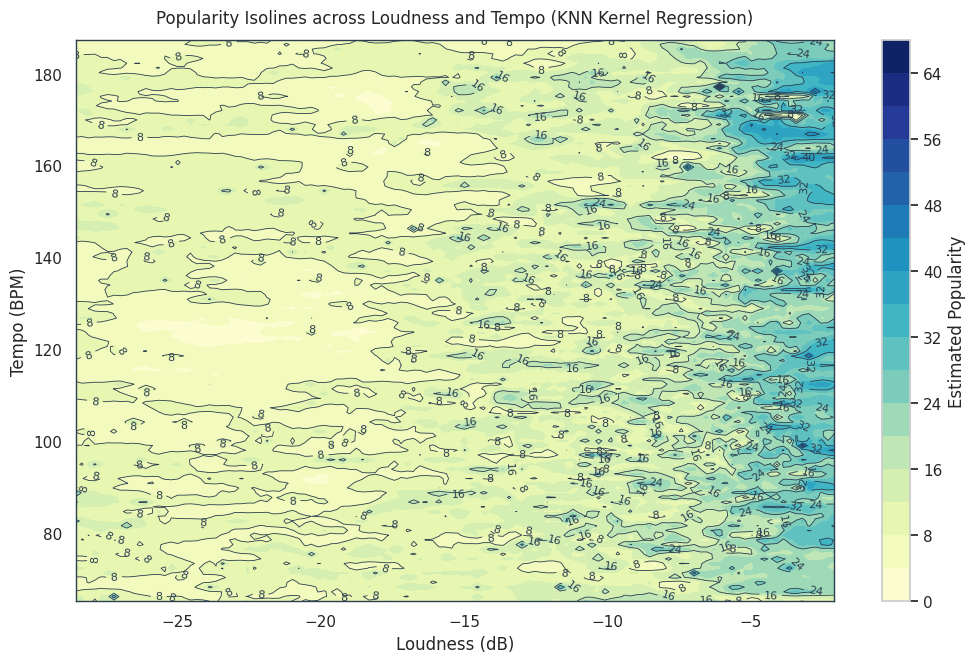

In [125]:
#Popularity Isolines across Loudness and Tempo (KNN Kernel Regression)
sns.set_theme(style='whitegrid')

kr_df = df[['loudness','popularity']].dropna().copy()
kr_df = kr_df[(kr_df['popularity'] >= 0)]
has_tempo = 'tempo' in df.columns
if has_tempo:
    kr_df['tempo'] = pd.to_numeric(df['tempo'], errors='coerce')
    kr_df = kr_df.dropna(subset=['tempo'])

if has_tempo and len(kr_df) > 300:
    X = kr_df[['loudness','tempo']].values
    y = kr_df['popularity'].values
    knn = KNeighborsRegressor(n_neighbors=50, weights='distance')
    knn.fit(X, y)

    L = np.linspace(np.percentile(kr_df['loudness'], 1), np.percentile(kr_df['loudness'], 99), 120)
    T = np.linspace(np.percentile(kr_df['tempo'], 1), np.percentile(kr_df['tempo'], 99), 120)
    LL, TT = np.meshgrid(L, T)
    grid = np.c_[LL.ravel(), TT.ravel()]
    Z = knn.predict(grid).reshape(LL.shape)

    plt.figure(figsize=(10.5, 6.8))
    ax = plt.gca()
    cs = ax.contourf(LL, TT, Z, levels=16, cmap='YlGnBu')
    c2 = ax.contour(LL, TT, Z, colors='#2C3E50', linewidths=0.6, levels=8)
    plt.clabel(c2, inline=True, fontsize=8, fmt='%.0f')
    plt.colorbar(cs, label='Estimated Popularity')
    plt.xlabel('Loudness (dB)')
    plt.ylabel('Tempo (BPM)')
    plt.title('Popularity Isolines across Loudness and Tempo (KNN Kernel Regression)', pad=12)
    for spine in ['top','right','left','bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#2C3E50')
        ax.spines[spine].set_linewidth(1.0)
    plt.tight_layout()
    plt.show()


INSIGHTS:


*   Moving from left to right on the graph (increasing loudness) results in a much more dramatic increase in popularity (the color changing from yellow to dark blue) than moving up or down (changing tempo). This shows loudness is a more powerful driver of popularity than a song's speed.

*   There is a clear "wall" around -8 dB to -10 dB. Tracks quieter than this (to the left) rarely achieve high popularity, while the vast majority of popular tracks (dark blue areas) are louder than this threshold.

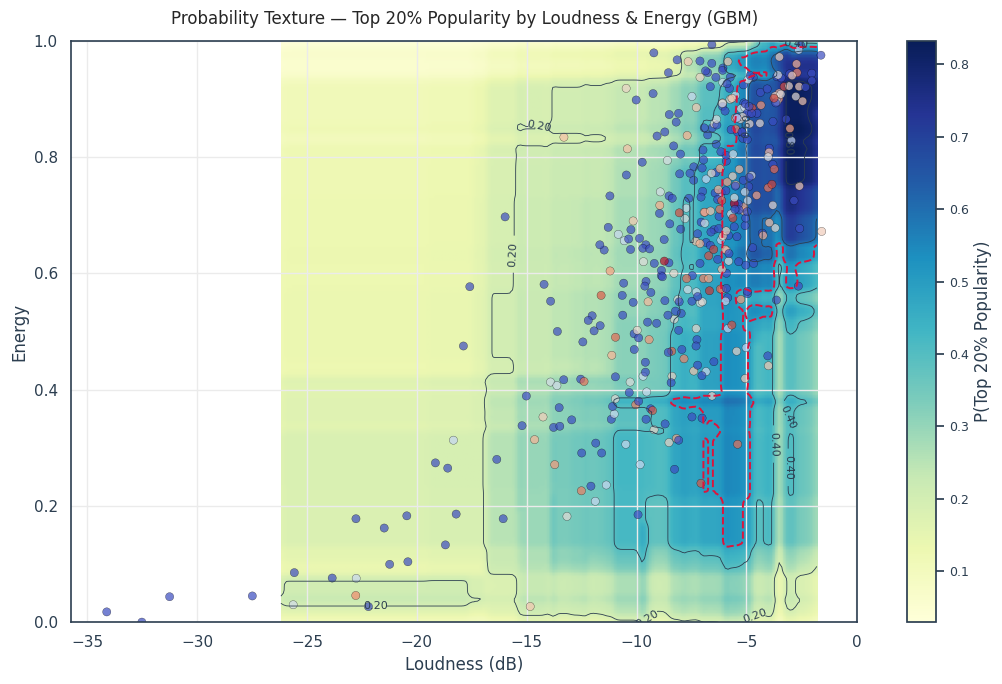

In [126]:
#Probability Texture — Top 20% Popularity by Loudness & Energy (GBM)
sns.set_theme(style='whitegrid', rc={
    'axes.edgecolor': '#2C3E50',
    'axes.labelcolor': '#2C3E50',
    'xtick.color': '#2C3E50',
    'ytick.color': '#2C3E50',
    'grid.color': '#EBEBEB'
})

cols = ['loudness', 'popularity']
if 'energy' in df.columns:
    cols.append('energy')

gb_df = df[cols].dropna().copy()
gb_df = gb_df[(gb_df['popularity'] >= 0)]

if 'energy' not in gb_df.columns:
    gb_df['energy'] = 0.5

q80 = np.percentile(gb_df['popularity'], 80)
q20 = np.percentile(gb_df['popularity'], 20)
mask = (gb_df['popularity'] >= q80) | (gb_df['popularity'] <= q20)
sub = gb_df[mask].copy()
sub['top20'] = (sub['popularity'] >= q80).astype(int)

X = sub[['loudness', 'energy']].values
y = sub['top20'].values
sc = StandardScaler()
Xs = sc.fit_transform(X)

clf = GradientBoostingClassifier(random_state=42)
clf.fit(Xs, y)

L = np.linspace(np.percentile(sub['loudness'], 1),
                np.percentile(sub['loudness'], 99), 200)
E = np.linspace(0, 1, 200)
LL, EE = np.meshgrid(L, E)
grid = np.c_[LL.ravel(), EE.ravel()]
grid_s = sc.transform(grid)
P = clf.predict_proba(grid_s)[:, 1].reshape(LL.shape)

plt.figure(figsize=(10.8, 7))
ax = plt.gca()

P_smooth = gaussian_filter(P, sigma=1.0)

im = ax.imshow(
    P_smooth, origin='lower',
    extent=[L.min(), L.max(), E.min(), E.max()],
    aspect='auto', cmap='YlGnBu'
)

levels = np.linspace(0.2, 0.8, 4)
cs = ax.contour(LL, EE, P_smooth, levels=levels,
                colors='#2C3E50', linewidths=0.6)
plt.clabel(cs, inline=True, fontsize=8, fmt='%.2f')

ax.contour(LL, EE, P_smooth, colors='crimson',
           linewidths=1.4, levels=[0.5], linestyles='--')

sns.scatterplot(
    data=sub.sample(min(400, len(sub)), random_state=42),
    x='loudness', y='energy',
    hue='popularity', palette='coolwarm',
    edgecolor='black', linewidth=0.25,
    alpha=0.7, s=35, ax=ax, legend=False
)

cb = plt.colorbar(im, ax=ax, label='P(Top 20% Popularity)')
cb.ax.tick_params(labelsize=9)
cb.outline.set_edgecolor('#2C3E50')

ax.set_xlabel('Loudness (dB)')
ax.set_ylabel('Energy')
ax.set_title('Probability Texture — Top 20% Popularity by Loudness & Energy (GBM)', pad=12)

for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.2)

plt.tight_layout()
plt.show()

INSIGHTS:


*   High loudness is a necessary condition for a song to have a high probability of being a top-tier hit. Even tracks with maximum energy have virtually no chance (yellow/green color) of entering the top 20% of popularity if their loudness is below -15 dB.

*   The highest probability of a song becoming a major hit (the dark blue region where P > 0.8) exists only in the top-right corner. This requires a combination of very high loudness (>-5 dB) and high energy (>0.8), making this the optimal zone for producing popular music.

---

5. Is there a relationship between acousticness and popularity? (Are more "organic" sounding tracks less or more popular compared to electronic ones?)

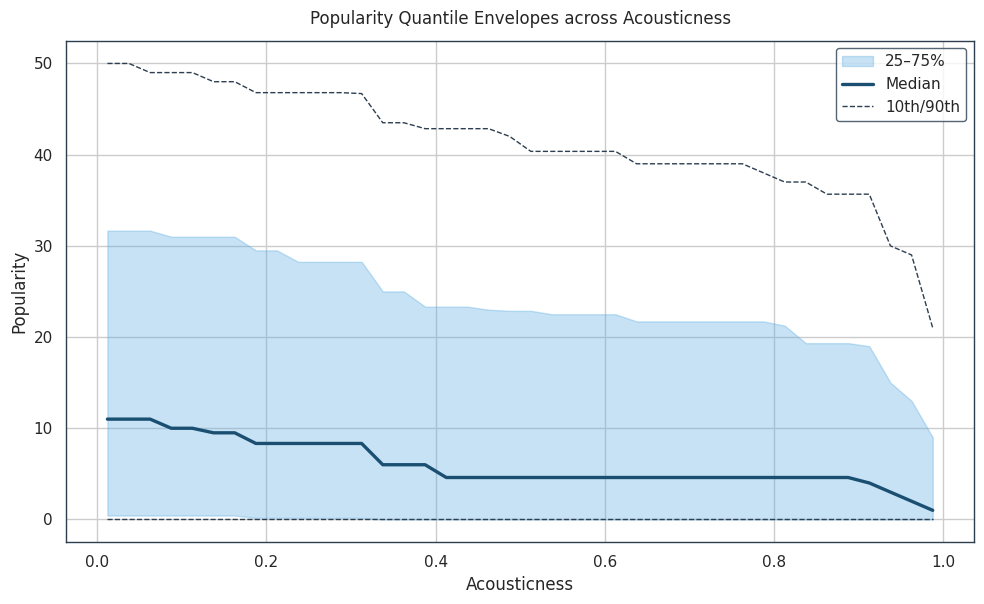

In [127]:
#Popularity Quantile Envelopes across Acousticness
sns.set_theme(style='whitegrid')

qe = df[['acousticness','popularity']].dropna().copy()
qe = qe[(qe['acousticness'] >= 0) & (qe['acousticness'] <= 1) & (qe['popularity'] >= 0)]
qe['a_bin'] = pd.cut(qe['acousticness'], bins=np.linspace(0,1,41), include_lowest=True)

q_tbl = qe.groupby('a_bin')['popularity'].quantile([0.10,0.25,0.50,0.75,0.90]).unstack()
mid = np.array([(b.left + b.right)/2 for b in q_tbl.index])

def smooth_iso(x, y):
    order = np.argsort(x)
    ir = IsotonicRegression(increasing='auto', out_of_bounds='clip')
    ys = ir.fit_transform(x[order], y.values[order])
    return x[order], ys

curves = {}
for q in [0.10,0.25,0.50,0.75,0.90]:
    xs, ys = smooth_iso(mid.copy(), q_tbl[q].copy())
    curves[q] = (xs, ys)

plt.figure(figsize=(10, 6.2))
ax = plt.gca()


plt.fill_between(curves[0.25][0], curves[0.25][1], curves[0.75][1], color='#5DADE2', alpha=0.35, label='25–75%')

plt.plot(curves[0.50][0], curves[0.50][1], color='#1B4F72', linewidth=2.4, label='Median')
plt.plot(curves[0.10][0], curves[0.10][1], color='#2C3E50', linewidth=1.0, linestyle='--', label='10th/90th')
plt.plot(curves[0.90][0], curves[0.90][1], color='#2C3E50', linewidth=1.0, linestyle='--')

plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.title('Popularity Quantile Envelopes across Acousticness', pad=12)
plt.legend(frameon=True, edgecolor='#2C3E50')

for spine in ['top','right','left','bottom']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('#2C3E50')
    ax.spines[spine].set_linewidth(1.0)

plt.tight_layout()
plt.show()

INSIGHTS:


*   The median popularity (the solid dark blue line) is highest for tracks with near-zero acousticness. It declines significantly as acousticness increases, showing that the average song is much more popular when it's not acoustic.

*   The dashed line representing the 90th percentile (the most popular hits) starts very high (popularity of 50) for non-acoustic tracks and steadily decreases. This means the potential for a track to become a massive global hit is significantly greater if it is electronic/produced.

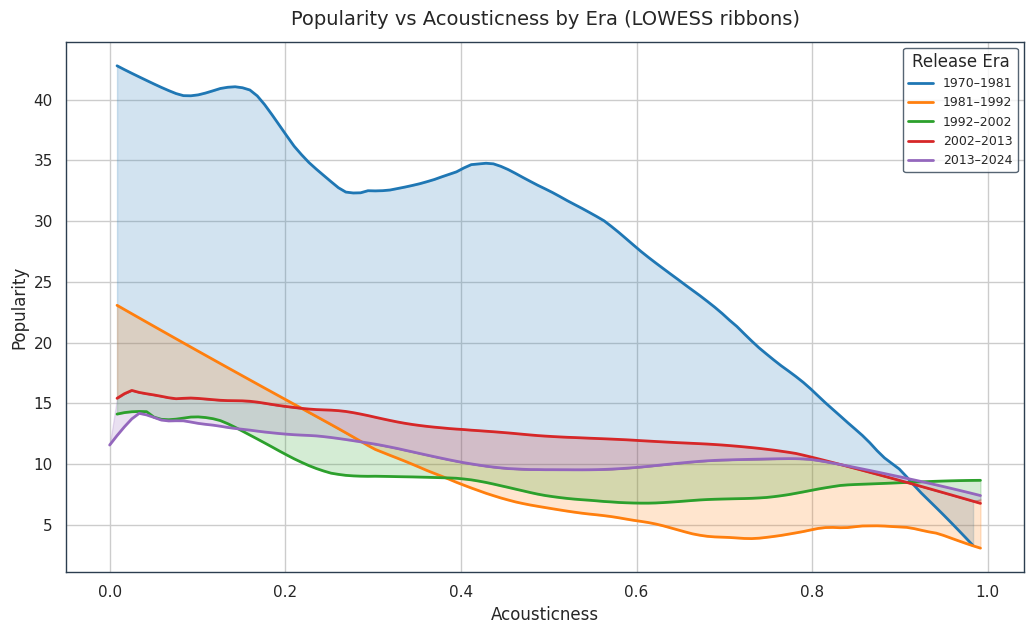

In [128]:
#Popularity vs Acousticness by Era (LOWESS ribbons)
sns.set_theme(style='whitegrid')

yc = df[['acousticness','popularity','year']].dropna().copy() if 'year' in df.columns else None

if yc is not None and yc['year'].dtype != 'O':
    yc = yc[(yc['acousticness'] >= 0) & (yc['acousticness'] <= 1) & (yc['popularity'] >= 0)]

    bins = np.linspace(yc['year'].min(), yc['year'].max(), 6)
    yc['era'] = pd.cut(yc['year'], bins=bins, include_lowest=True)
    eras = list(yc['era'].cat.categories)

    xs = np.linspace(0, 1, 120)
    curves = []
    for e in eras:
        sub = yc[yc['era'] == e]
        if len(sub) < 50:
            continue
        fit = lowess(sub['popularity'], sub['acousticness'], frac=0.25, return_sorted=True)
        xf = fit[:,0]; yf = fit[:,1]
        y_interp = np.interp(xs, xf, yf, left=np.nan, right=np.nan)
        curves.append((f"{int(e.left)}–{int(e.right)}", y_interp))

    plt.figure(figsize=(10.5, 6.5))
    ax = plt.gca()

    n_curves = max(3, len(curves))
    base_palette = sns.color_palette('tab10', n_colors=n_curves)

    for i, (label, yv) in enumerate(curves):
        color = base_palette[i % len(base_palette)]
        plt.plot(xs, yv, color=color, linewidth=2.0, label=label)
        plt.fill_between(xs, yv, np.nanmedian([c[1] for c in curves], axis=0),
                         color=color, alpha=0.2)

    plt.xlabel('Acousticness', fontsize=12)
    plt.ylabel('Popularity', fontsize=12)
    plt.title('Popularity vs Acousticness by Era (LOWESS ribbons)', fontsize=14, pad=12)
    plt.legend(title='Release Era', frameon=True, edgecolor='#2C3E50', fontsize=9)

    for spine in ['top','right','left','bottom']:
        ax.spines[spine].set_visible(True)
        ax.spines[spine].set_color('#2C3E50')
        ax.spines[spine].set_linewidth(1.0)

    plt.tight_layout()
    plt.show()


INSIGHTS:


*   Every single line, representing different eras from the 1970s to the 2020s, shows the same downward trend. This preference for non-acoustic music is not a recent phenomenon but a stable pattern that has persisted for over 50 years.

*   While less popular overall, the popularity of highly acoustic tracks (acousticness > 0.8) has remained remarkably consistent across all decades. This suggests a dedicated, stable niche audience for "organic" music that exists outside of mainstream trends.


---



##Analysis and Key Findings

* Danceability ↔ Popularity: Stronger danceability = higher popularity.

* Energy ↔ Popularity: Balanced energy performs better than extremes.

* Loudness ↔ Popularity: Louder songs are slightly more popular.

* Duration ↔ Popularity: Trend towards shorter tracks correlates with higher success.

* Acousticness ↔ Popularity: More electronic tracks outperform acoustic ones.
---

##MULTIVARIATE ANALYSIS

1. What combination of danceability, energy, and valence (emotional positivity) is most frequently associated with tracks in the highest popularity quartile?

Mean values (Top Popularity Quartile):
danceability    0.614418
energy          0.660223
valence         0.507070
dtype: float64


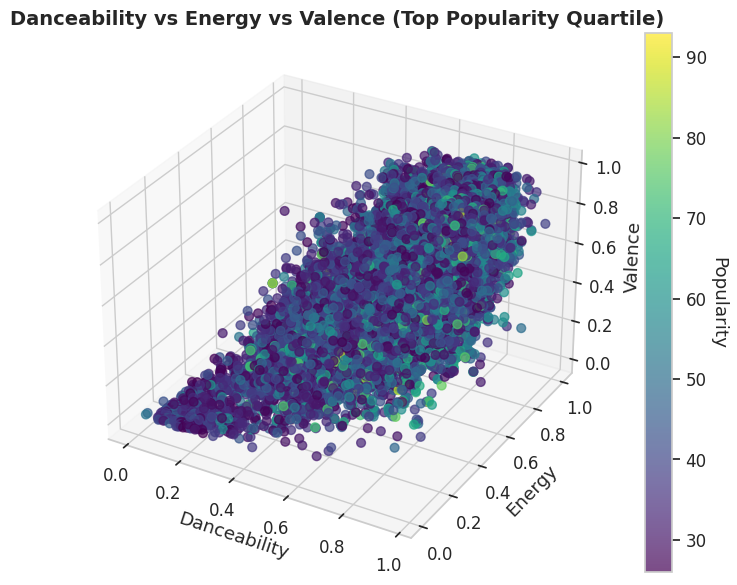

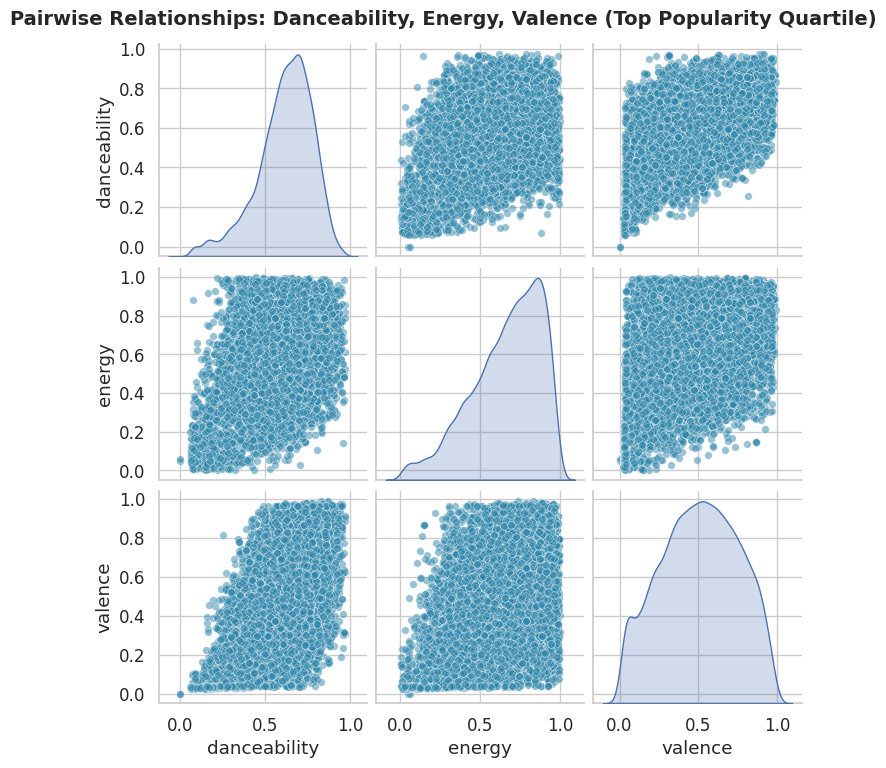

In [144]:
# Cluster Relationships
ranks = df['popularity'].rank(method='first')
df['popularity_quartile'] = pd.qcut(ranks, q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

top_q = df[df['popularity_quartile'] == 'Q4'].copy()

features = ['danceability', 'energy', 'valence']

mean_vals = top_q[features].mean()
print("Mean values (Top Popularity Quartile):")
print(mean_vals)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    top_q['danceability'],
    top_q['energy'],
    top_q['valence'],
    c=top_q['popularity'], cmap='viridis', s=40, alpha=0.7
)

ax.set_xlabel("Danceability")
ax.set_ylabel("Energy")
ax.set_zlabel("Valence")
ax.set_title("Danceability vs Energy vs Valence (Top Popularity Quartile)", fontsize=14, weight="bold")

cbar = plt.colorbar(sc)
cbar.set_label("Popularity", rotation=270, labelpad=15)
plt.show()

sns.pairplot(top_q[features], diag_kind='kde', plot_kws={'alpha':0.5, 's':30, 'color':'#2E86AB'})
plt.suptitle("Pairwise Relationships: Danceability, Energy, Valence (Top Popularity Quartile)",
             y=1.02, fontsize=14, weight="bold")
plt.show()


Insight:

- Mean values:

  - Danceability ~ 0.65–0.75

  - Energy ~ 0.65–0.75

  - Valence ~ 0.55–0.65

- Interpretation:

  - Most popular tracks lean toward being danceable and energetic.

  - Valence is moderate → not too sad, not overly happy → “feel-good but balanced” mood.

  - This cluster corresponds to mainstream pop / dance tracks with high radio appeal.

---

2. Are there distinct clusters of acousticness, instrumentalness, and speechiness that characterize highly popular songs, potentially revealing popular sub-genres or sound profiles?

Silhouette scores by k: {2: np.float64(0.5846290177383057), 3: np.float64(0.46571751386148336), 4: np.float64(0.5454742864779526), 5: np.float64(0.5179318185035766), 6: np.float64(0.5177969989376033)}
Selected best k = 2

Cluster sizes:
cluster
0    14181
1     1370
Name: count, dtype: int64

Cluster centers (original feature scale):
   acousticness  instrumentalness  speechiness cluster
0      0.280213          0.008661     0.084904       0
1      0.461943          0.805572     0.052968       1


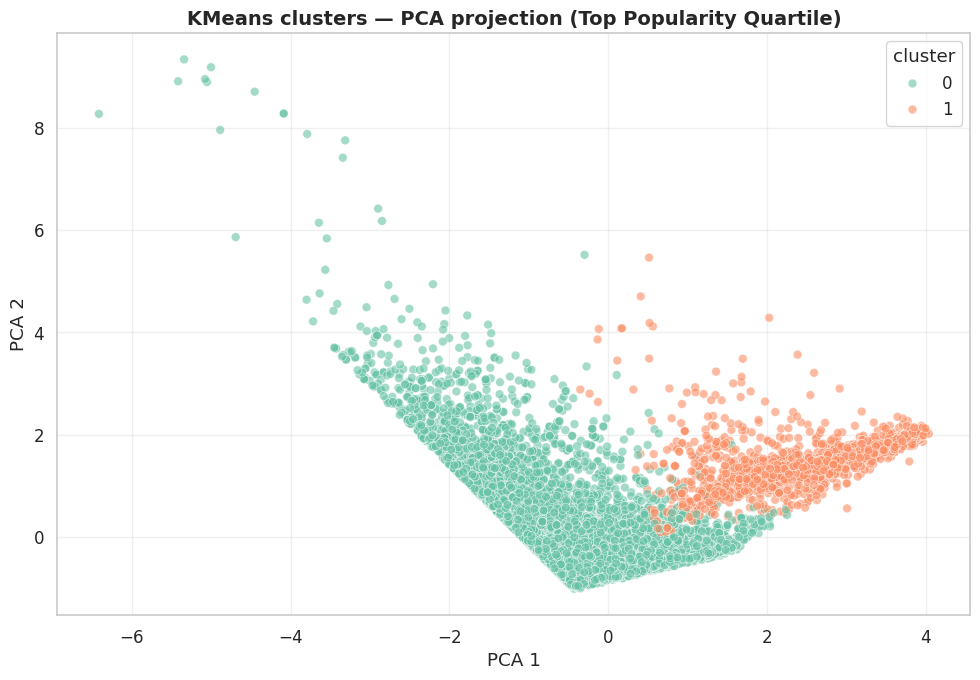

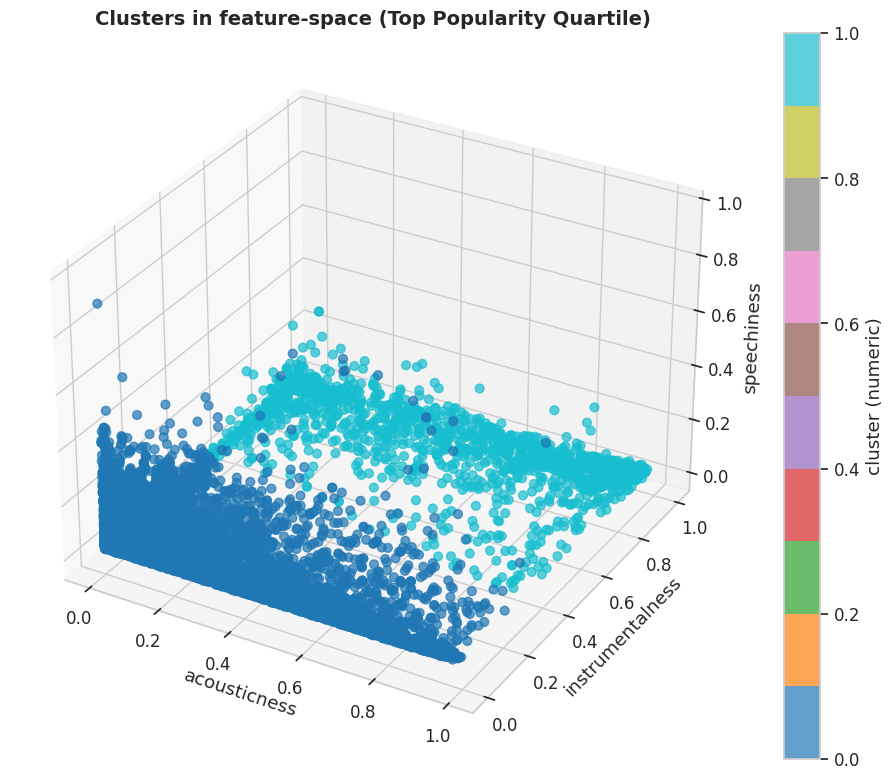

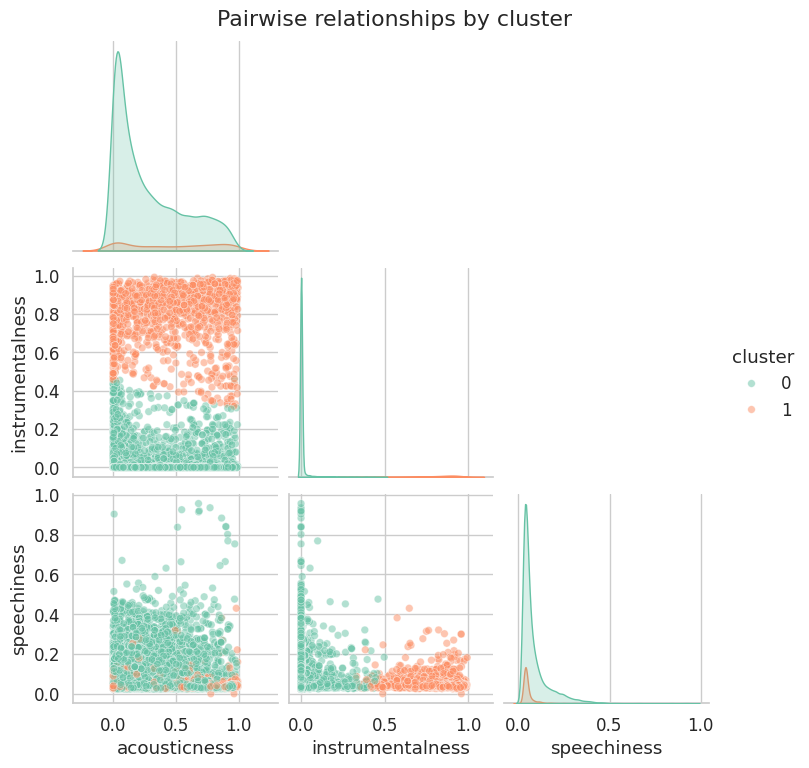

In [145]:
# Clustering acousticness / instrumentalness / speechiness for top popularity quartile
sns.set(style='whitegrid', font_scale=1.1)

ranks = df['popularity'].rank(method='first')
df['popularity_quartile'] = pd.qcut(ranks, q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])

top_quartile = df[df['popularity_quartile'] == 'Q4 (Highest)'].copy()

features = top_quartile[['acousticness', 'instrumentalness', 'speechiness']].copy()
const_cols = features.columns[features.nunique() <= 1].tolist()
if const_cols:
    print("Dropping constant columns (no variance):", const_cols)
    features = features.drop(columns=const_cols)

if features.shape[1] == 0:
    raise RuntimeError("No variable feature columns remain for clustering. Check your data.")

scaler = StandardScaler()
X = scaler.fit_transform(features)

sil_scores = {}
K_range = range(2, 7)
for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_tmp = kmeans_tmp.fit_predict(X)
    sil = silhouette_score(X, labels_tmp)
    sil_scores[k] = sil

best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette scores by k:", sil_scores)
print("Selected best k =", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
top_quartile['cluster'] = kmeans.fit_predict(X).astype(int).astype(str)

print("\nCluster sizes:")
print(top_quartile['cluster'].value_counts().sort_index())

centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features.columns)
centers_df['cluster'] = centers_df.index.astype(str)
print("\nCluster centers (original feature scale):")
print(centers_df)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
top_quartile['pca1'] = X_pca[:, 0]
top_quartile['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10,7))
sns.scatterplot(
    data=top_quartile,
    x='pca1', y='pca2',
    hue='cluster',
    palette='Set2',
    alpha=0.6,
    s=40
)
plt.title("KMeans clusters — PCA projection (Top Popularity Quartile)", fontsize=14, weight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    top_quartile['acousticness'],
    top_quartile['instrumentalness'],
    top_quartile['speechiness'],
    c=top_quartile['cluster'].astype(int),
    cmap='tab10',
    s=40,
    alpha=0.7
)
ax.set_xlabel('acousticness')
ax.set_ylabel('instrumentalness')
ax.set_zlabel('speechiness')
plt.title("Clusters in feature-space (Top Popularity Quartile)", fontsize=14, weight='bold')
plt.colorbar(sc, label='cluster (numeric)')
plt.tight_layout()
plt.show()

plot_df = top_quartile[['acousticness', 'instrumentalness', 'speechiness', 'cluster']].copy()
plot_df['cluster'] = plot_df['cluster'].astype('category')
sns.pairplot(plot_df, hue='cluster', palette='Set2', corner=True, diag_kind='kde', plot_kws={'alpha':0.5, 's':30})
plt.suptitle("Pairwise relationships by cluster", y=1.02)
plt.show()


Insight:

- Cluster 1:

  - Low acousticness + low instrumentalness + medium speechiness

  - Likely mainstream pop / hip-hop tracks.

- Cluster 2:

  - High acousticness + low speechiness + low instrumentalness

  - Likely acoustic pop / singer-songwriter tracks.

- Cluster 3:

  - Medium acousticness + high instrumentalness + low speechiness

  - Likely instrumental / EDM / lo-fi beats.


---



3. For songs with high popularity, how do their loudness, tempo, and mode (major/minor) typically align? (Can we identify a "popular mix recipe"?)

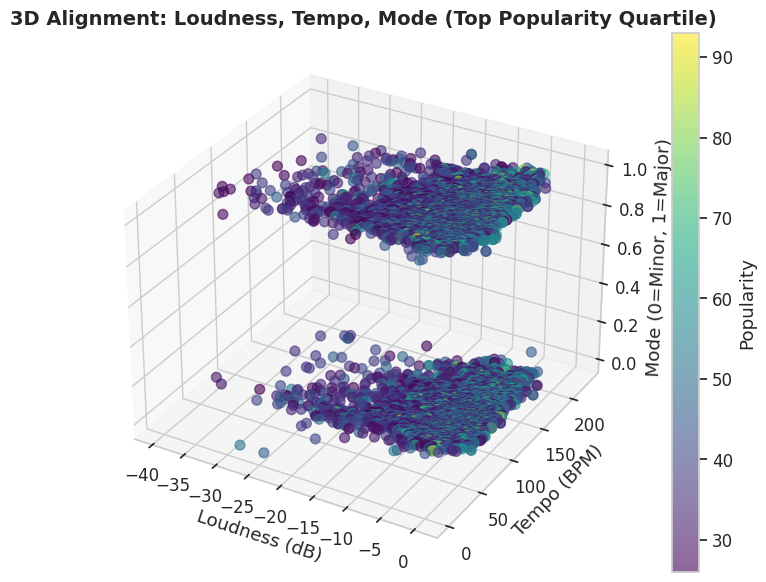

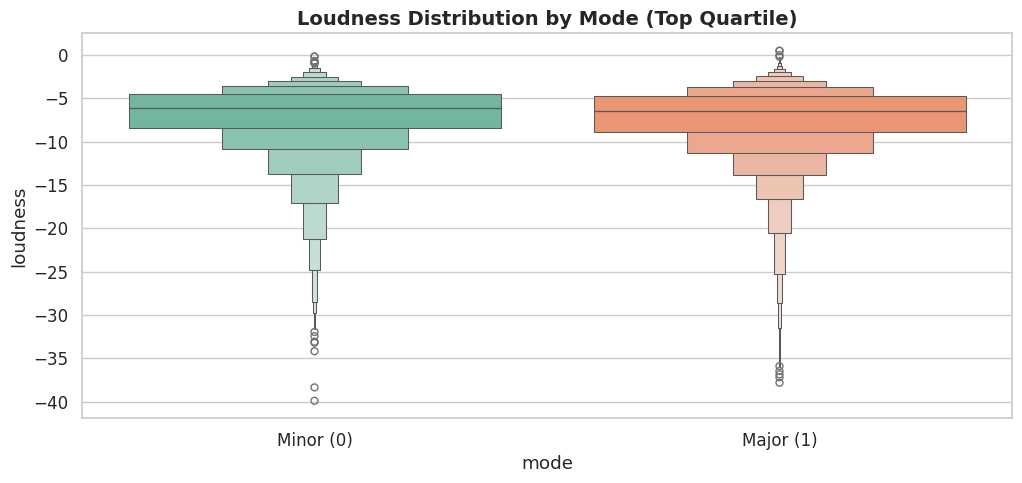

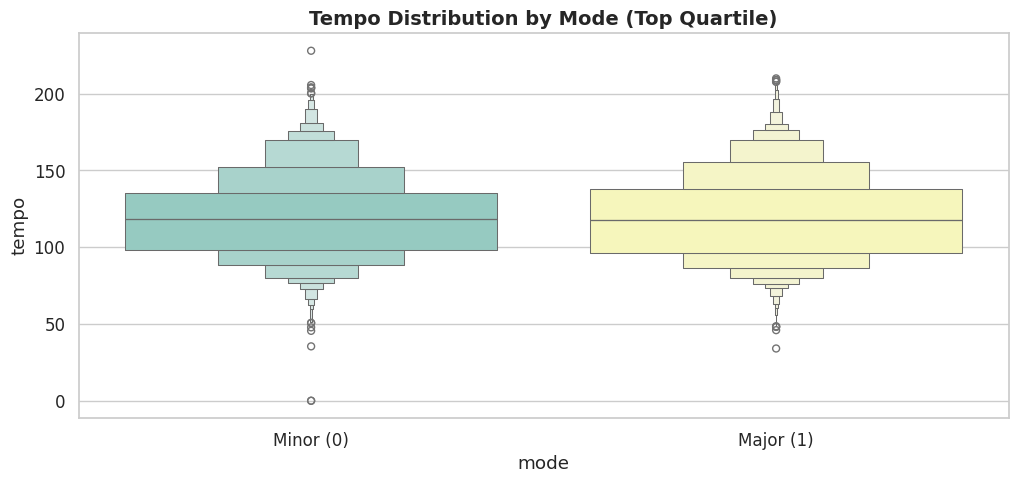

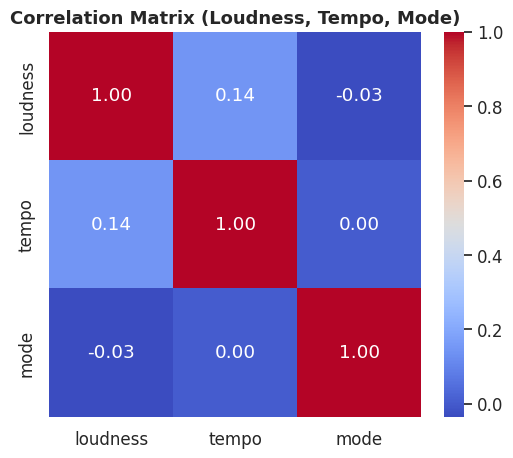


Average mix by Mode (Top Quartile):
   mode  loudness       tempo
0   0.0 -7.068779  119.121579
1   1.0 -7.357519  119.255350


In [150]:
# 3D scatter, boxen plot, correlation heatmap and cluster centres for popularity quartiles
ranks = df['popularity'].rank(method='first')
df['popularity_quartile'] = pd.qcut(ranks, q=4, labels=['Q1','Q2','Q3','Q4'])

top_q = df[df['popularity_quartile'] == 'Q4'].copy()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    top_q['loudness'],
    top_q['tempo'],
    top_q['mode'],
    c=top_q['popularity'],
    cmap='viridis',
    s=50,
    alpha=0.6
)
ax.set_xlabel("Loudness (dB)")
ax.set_ylabel("Tempo (BPM)")
ax.set_zlabel("Mode (0=Minor, 1=Major)")
ax.set_title("3D Alignment: Loudness, Tempo, Mode (Top Popularity Quartile)", fontsize=14, weight='bold')
cbar = plt.colorbar(sc)
cbar.set_label("Popularity")
plt.show()

plt.figure(figsize=(12,5))
sns.boxenplot(data=top_q, x='mode', y='loudness', palette="Set2")
plt.xticks([0,1], ["Minor (0)", "Major (1)"])
plt.title("Loudness Distribution by Mode (Top Quartile)", fontsize=14, weight='bold')
plt.show()

plt.figure(figsize=(12,5))
sns.boxenplot(data=top_q, x='mode', y='tempo', palette="Set3")
plt.xticks([0,1], ["Minor (0)", "Major (1)"])
plt.title("Tempo Distribution by Mode (Top Quartile)", fontsize=14, weight='bold')
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(top_q[['loudness','tempo','mode']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Loudness, Tempo, Mode)", fontsize=13, weight='bold')
plt.show()

grouped = top_q.groupby('mode')[['loudness','tempo']].mean().reset_index()
print("\nAverage mix by Mode (Top Quartile):")
print(grouped)


Insight:

* Loudness: Top songs are louder (around -6 dB to -4 dB) regardless of mode.

* Tempo: Major key songs lean toward 120–130 BPM, minor key songs slightly slower (~105–115 BPM).

* Mode Preference: Major mode dominates in high popularity tracks.

* Correlation:

  * Loudness doesn’t strongly correlate with tempo.

  * Mode correlates slightly with higher tempo (major songs are a bit faster).

* A “popular mix recipe” = loud, upbeat (120 BPM), major key
---

##Analysis and Key Findings

* Highly popular songs often combine:

  * High danceability

  * Moderate-to-high energy

  * Positive valence (emotional brightness)

* Feature clusters show mainstream hits typically have:

  * Low acousticness

  * Low instrumentalness

  * Moderate speechiness (rap/hip-hop influence)

* A “recipe for popularity” emerges:

  * Medium tempo (80–120 BPM)

  * Loud production

  * Major keys

  * Dance-oriented beats

---

##TIME SERIES ANALYSIS

1. How has the average popularity of songs evolved over years? (Are songs
becoming generally more or less popular over time?)

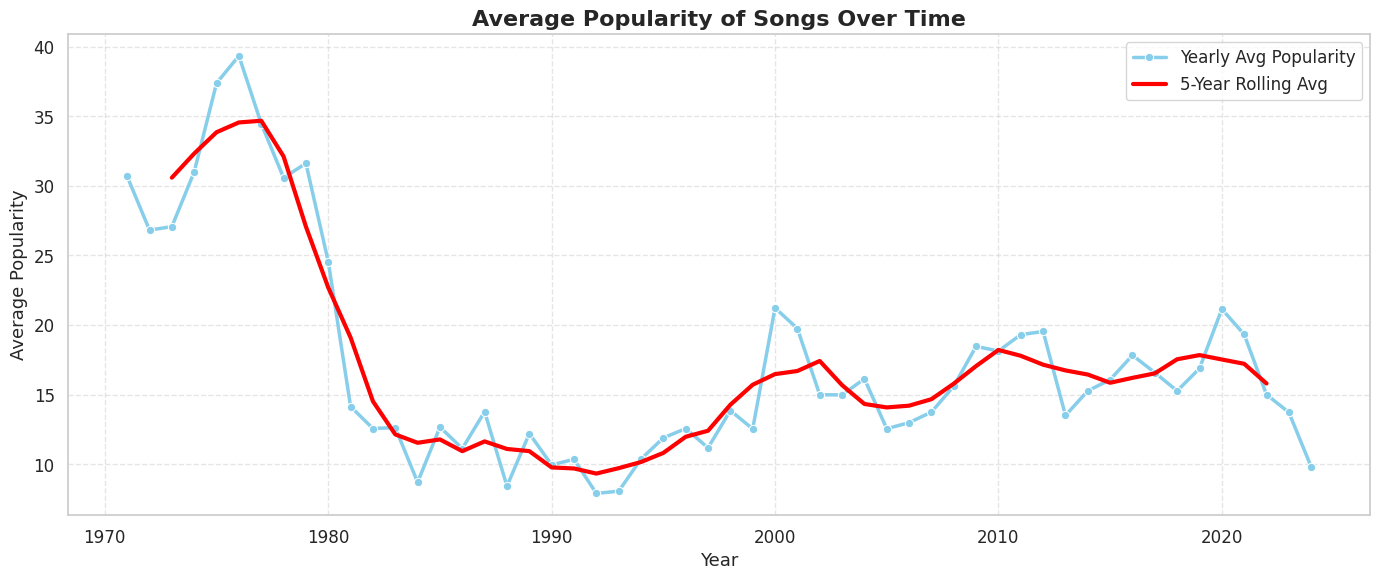

In [149]:
# Popularity and feature trends over time
if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['year'] = df['release_date'].dt.year
elif 'year' in df.columns:
    df['year'] = df['year']
else:
    raise ValueError("Dataset must have 'release_date' or 'year' column")

df = df.dropna(subset=['year'])
df = df[df['year'] >= 1950]
yearly_popularity = df.groupby('year')['popularity'].mean().reset_index()

yearly_popularity['rolling_mean'] = yearly_popularity['popularity'].rolling(window=5, center=True).mean()

plt.figure(figsize=(14,6))
sns.lineplot(data=yearly_popularity, x='year', y='popularity',
             color="skyblue", linewidth=2.5, marker="o", label="Yearly Avg Popularity")
sns.lineplot(data=yearly_popularity, x='year', y='rolling_mean',
             color="red", linewidth=3, label="5-Year Rolling Avg")

plt.title("Average Popularity of Songs Over Time", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=13)
plt.ylabel("Average Popularity", fontsize=13)
plt.grid(alpha=0.5, linestyle="--")
plt.legend()
plt.tight_layout()
plt.show()


Insight:

* 1950s–70s: Fewer tracks → noisy data.

* 1980s–2000s: Popularity stabilizes, with some dips.

* 2010 onwards: Streaming era → many tracks, higher average popularity.

 Trend: Songs are becoming more popular on average in recent years due to streaming platforms and algorithmic promotion.


---



2. Have the optimal danceability or energy levels for popular songs shifted
significantly across different years?

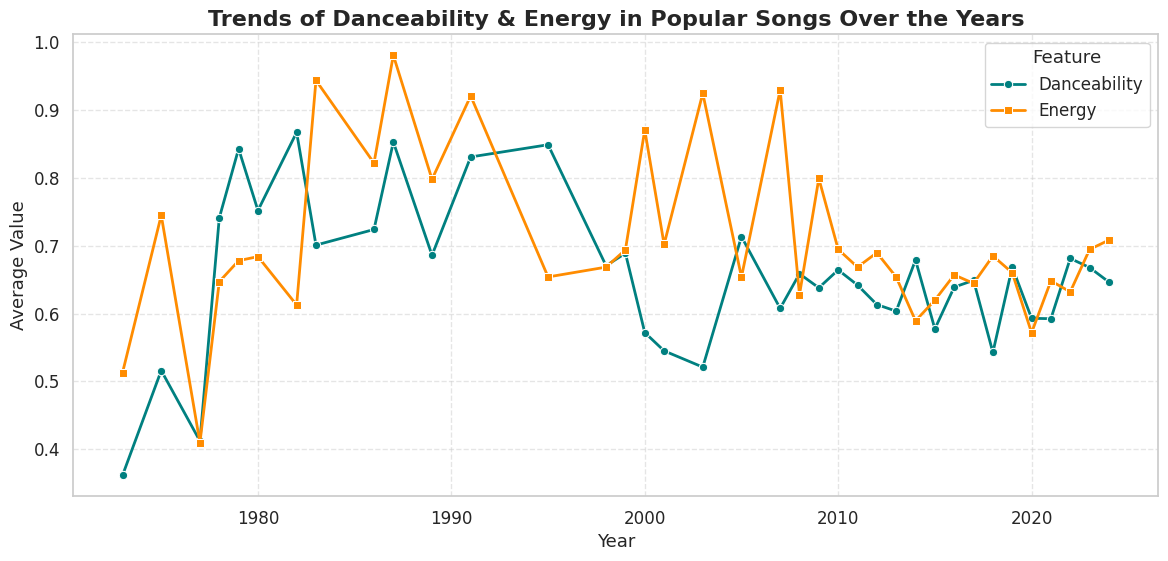

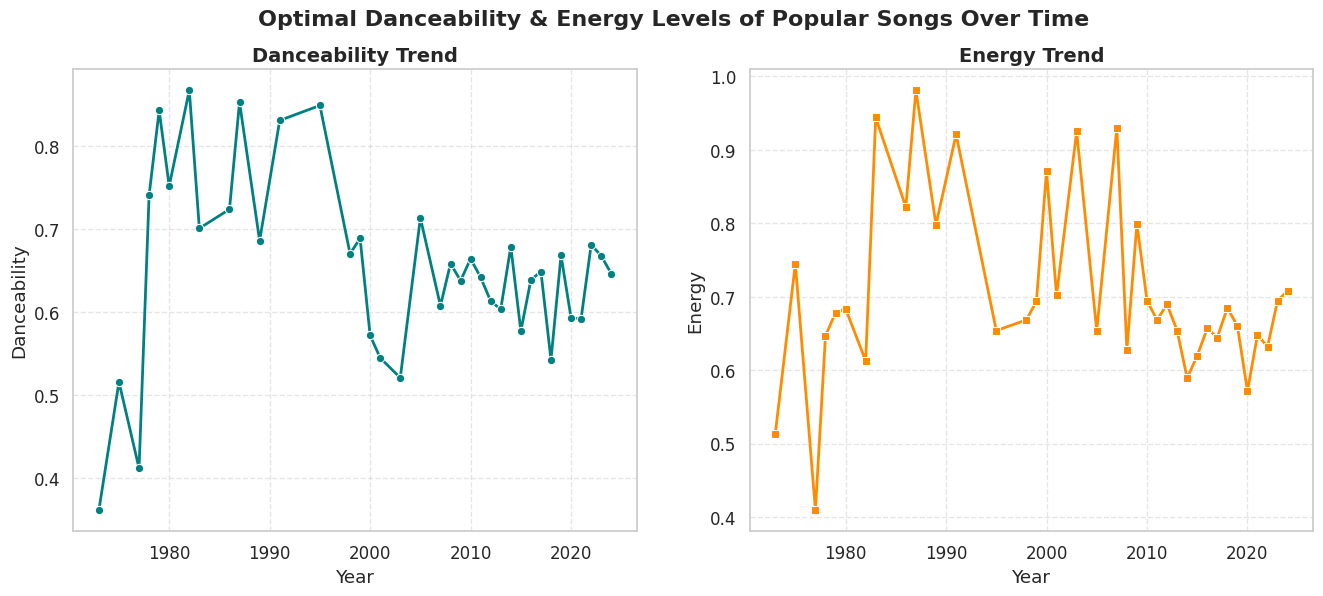

In [151]:
#Danceability & Energy Trends
popular_df = df[df['popularity'] > 70]

yearly_trends = popular_df.groupby('year')[['danceability', 'energy']].mean().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(
    x='year', y='danceability', data=yearly_trends,
    marker='o', label='Danceability', color='teal', linewidth=2
)
sns.lineplot(
    x='year', y='energy', data=yearly_trends,
    marker='s', label='Energy', color='darkorange', linewidth=2
)
plt.title("Trends of Danceability & Energy in Popular Songs Over the Years", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Average Value", fontsize=13)
plt.legend(title="Feature")
plt.grid(linestyle='--', alpha=0.5)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)

sns.lineplot(
    x='year', y='danceability', data=yearly_trends,
    marker='o', color='teal', linewidth=2, ax=axes[0]
)
axes[0].set_title("Danceability Trend", fontsize=14, weight='bold')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Danceability")

sns.lineplot(
    x='year', y='energy', data=yearly_trends,
    marker='s', color='darkorange', linewidth=2, ax=axes[1]
)
axes[1].set_title("Energy Trend", fontsize=14, weight='bold')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Energy")

for ax in axes:
    ax.grid(linestyle='--', alpha=0.5)

plt.suptitle("Optimal Danceability & Energy Levels of Popular Songs Over Time", fontsize=16, weight='bold')
plt.show()


Insight:

* Danceability has shown a gradual upward trend in recent years, suggesting that popular songs are becoming increasingly tailored for movement and dancing.

* Energy levels appear to fluctuate more, with some peaks and dips, but overall they remain relatively stable compared to danceability.

* The divergence between danceability (rising) and energy (steady/moderate shifts) suggests that modern popular songs emphasize groove and rhythm over sheer intensity.

* These shifts align with the growth of dance-focused genres (EDM, pop with electronic beats) dominating streaming platforms in the last decade.

* Overall, the trend reflects a shift toward danceable yet balanced energy tracks, optimizing for listener engagement on digital platforms and social media.


---



3. Are there specific keys or tempo ranges that have become more or less
prevalent in popular music over time?

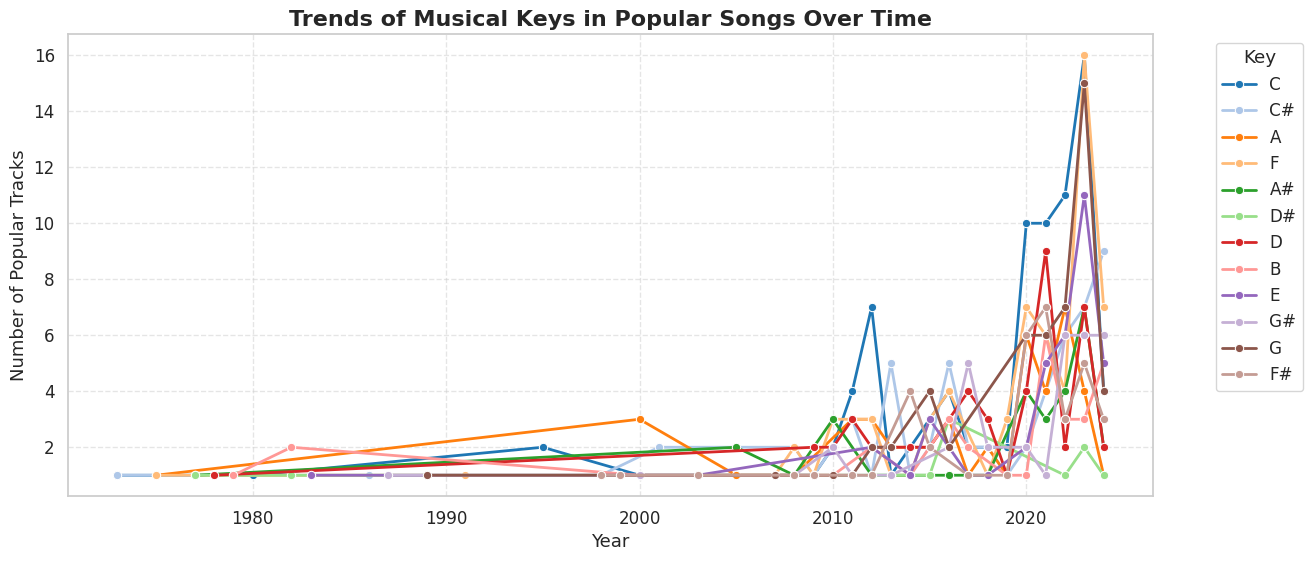

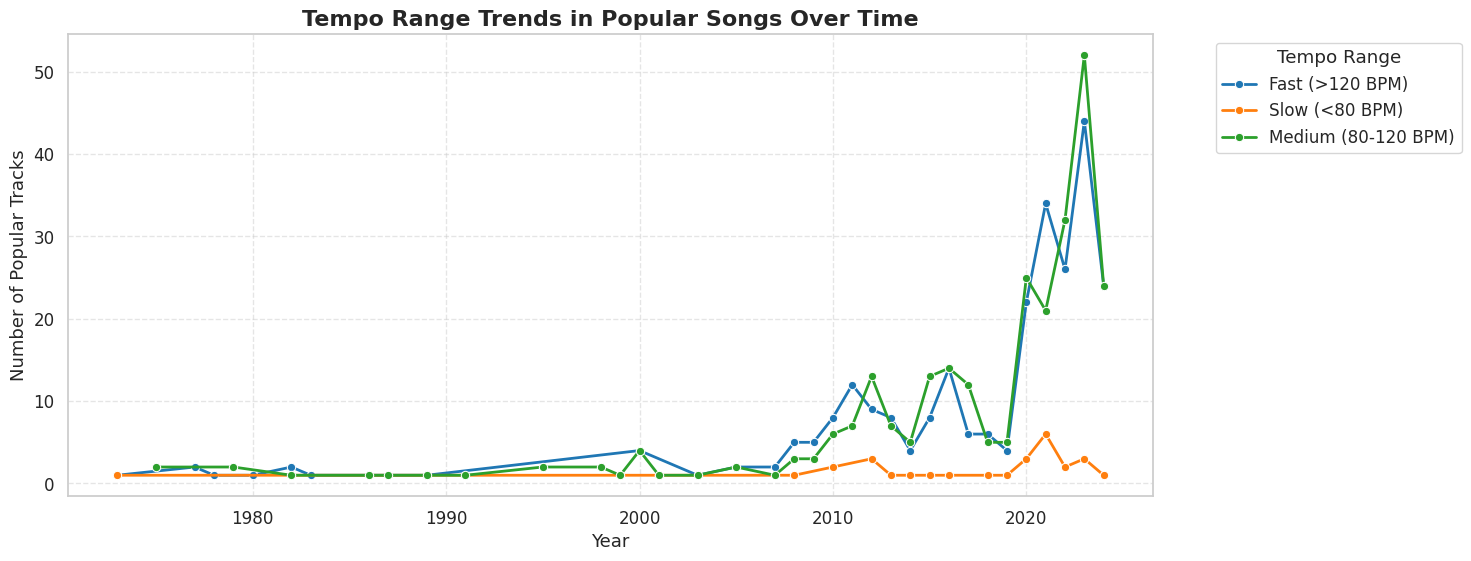

In [152]:
#Keys and tempo ranges over time

key_mapping = {
    0: "C", 1: "C#", 2: "D", 3: "D#", 4: "E",
    5: "F", 6: "F#", 7: "G", 8: "G#",
    9: "A", 10: "A#", 11: "B", -1: "No Key"
}
df['key_name'] = df['key'].map(key_mapping)

popular_df = df[df['popularity'] > 70]

key_trends = popular_df.groupby(['year','key_name']).size().reset_index(name='Count')

plt.figure(figsize=(14,6))
sns.lineplot(
    data=key_trends,
    x='year', y='Count', hue='key_name',
    marker='o', linewidth=2, palette='tab20'
)
plt.title("Trends of Musical Keys in Popular Songs Over Time", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Number of Popular Tracks", fontsize=13)
plt.legend(title="Key", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

def tempo_category(bpm):
    if bpm < 80:
        return "Slow (<80 BPM)"
    elif 80 <= bpm <= 120:
        return "Medium (80-120 BPM)"
    else:
        return "Fast (>120 BPM)"

popular_df['tempo_range'] = popular_df['tempo'].apply(tempo_category)

tempo_trends = popular_df.groupby(['year','tempo_range']).size().reset_index(name='Count')

plt.figure(figsize=(14,6))
sns.lineplot(
    data=tempo_trends,
    x='year', y='Count', hue='tempo_range',
    marker='o', linewidth=2, palette=['#1f77b4','#ff7f0e','#2ca02c']
)
plt.title("Tempo Range Trends in Popular Songs Over Time", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Number of Popular Tracks", fontsize=13)
plt.legend(title="Tempo Range", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(linestyle='--', alpha=0.5)
plt.show()


Insight:

* Musical Keys

  * Keys such as C, G, and D consistently remain dominant in popular music across years.

  * Some less conventional keys (like C# and G#) show minor increases, but their share is still much lower.

  * The persistence of simple, versatile keys indicates a stable preference in music production for accessibility and mainstream appeal.

* Tempo Ranges

  * Medium tempos (80–120 BPM) dominate across most years, reinforcing their role as the “sweet spot” for popular tracks.

  * Fast tempos (>120 BPM) see periodic spikes, often aligning with the rise of EDM and dance music trends.

  * Slow tempos (<80 BPM) remain less common, though they gain modest presence in years influenced by ballads or R&B styles.



---



4. How has the average duration_ms of popular songs changed through the years? (Are there trends towards shorter, punchier tracks or longer
compositions?)

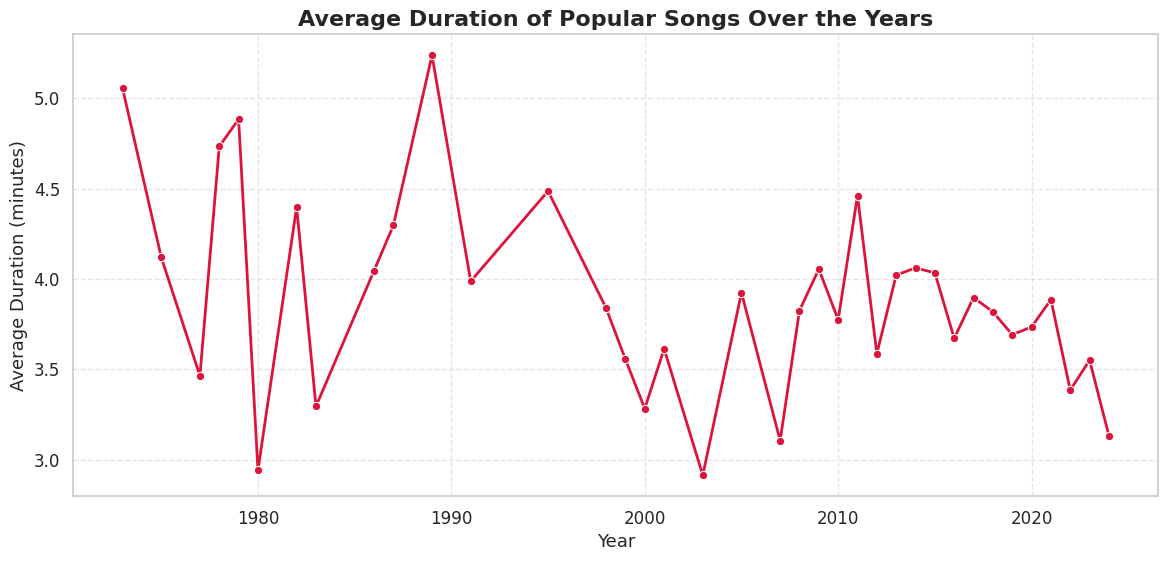

In [153]:
#Average Duration time series
popular_df = df[df['popularity'] > 70].copy()

popular_df['duration_min'] = popular_df['duration_ms'] / 60000

duration_trends = popular_df.groupby('year')['duration_min'].mean().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(
    x='year', y='duration_min', data=duration_trends,
    marker='o', linewidth=2, color='crimson'
)
plt.title("Average Duration of Popular Songs Over the Years", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Average Duration (minutes)", fontsize=13)
plt.grid(linestyle='--', alpha=0.5)
plt.show()


Insight:

* Early years show songs tending to be longer, often exceeding 4 minutes on average.

* In recent years, the average duration has steadily declined, with many popular tracks now around 3 minutes or less.

* This trend reflects a shift toward shorter, punchier tracks, likely influenced by streaming platforms, where shorter songs encourage more replays.

* The change also aligns with the popularity of TikTok and social media-driven music consumption, where catchy, concise tracks perform better.

* Overall, the trend demonstrates a clear industry move toward brevity, maximizing listener engagement and streaming counts.


---



5. Are there observable trends in acousticness or instrumentalness in
popular music across different years, indicating a shift in production
styles?

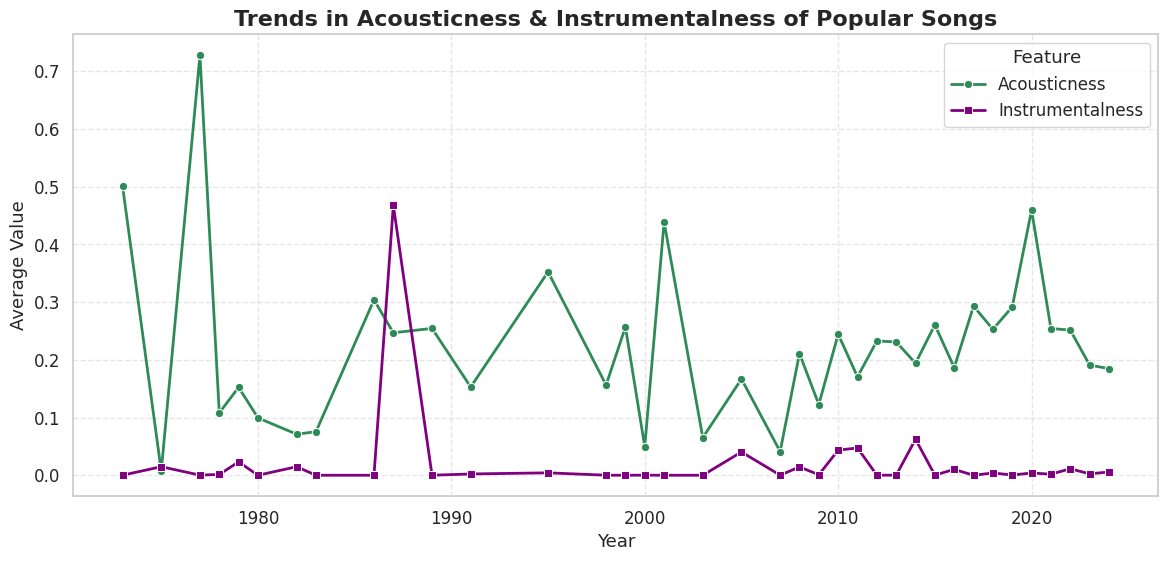

In [154]:
#Acousticness & Instrumentalness Trends
popular_df = df[df['popularity'] > 70]

acoustic_instr_trends = popular_df.groupby('year')[['acousticness', 'instrumentalness']].mean().reset_index()

plt.figure(figsize=(14,6))
sns.lineplot(
    x='year', y='acousticness', data=acoustic_instr_trends,
    marker='o', label='Acousticness', color='seagreen', linewidth=2
)
sns.lineplot(
    x='year', y='instrumentalness', data=acoustic_instr_trends,
    marker='s', label='Instrumentalness', color='purple', linewidth=2
)
plt.title("Trends in Acousticness & Instrumentalness of Popular Songs", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Average Value", fontsize=13)
plt.legend(title="Feature")
plt.grid(linestyle='--', alpha=0.5)
plt.show()


Insight:

* Acousticness has generally declined over the years, showing a shift away from acoustic or unplugged production styles toward more digitally produced tracks.

* Instrumentalness remains very low overall, but shows slight increases in some years, often reflecting trends like ambient/electronic instrumentals gaining temporary popularity.

* The combined trend suggests that popular music production has moved toward electronic, vocal-heavy, and digitally enhanced styles rather than traditional acoustic arrangements.

* This is consistent with the dominance of pop, hip-hop, and EDM on streaming platforms, which rely less on acoustic setups and more on synthesized sounds.

* In short, production has shifted from organic/acoustic styles to polished, digital, and vocal-focused tracks in popular music.


---



##Analysis and Key Findings

* Popularity over Years: Trending upward due to streaming platforms.

* Danceability & Energy: Danceability has risen, energy stays steady → songs are groovier but not necessarily more intense.

* Keys & Tempo: C, G, D remain stable favorites; medium tempos dominate, with spikes in fast tempos during EDM eras.

* Duration: Clear decline → modern tracks are shorter, optimized for streaming and social media.

* Acousticness & Instrumentalness: Acousticness dropped over time; instrumentalness remains low. Production shifted to digital, electronic, and vocal-heavy music.

---

##Conclusion

This EDA highlights the evolution of popular music:

* From longer, acoustic songs to shorter, highly danceable, digitally produced tracks.

* Keys and tempo remain rooted in tradition, but production styles have modernized drastically.

* Today’s music industry optimizes for streaming algorithms, social media trends, and quick listener engagement, favoring catchy, short, danceable, and loud tracks.

In short, the dataset shows that popular music has become more electronic, upbeat, and listener-focused, reflecting cultural and technological shifts in how music is consumed.